In [1]:
import numpy as np
import xarray as xr
import os
import fnmatch
from tqdm.autonotebook import tqdm
import dask
import sys
sys.path.insert(0, '/home/jovyan/CMIP6cf/cmip6cf/')
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%config InlineBackend.figure_format = 'retina'


/tmp/ipykernel_1984/3363248783.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Load output:

In [2]:
in_dir = '/home/jovyan/CMIP6cf/output/surge_pr_dependence/40yr_p97_declus5d/'
output_files = []
for root, dirs, files in os.walk(in_dir, topdown=False):
    for name in files:
        output_files.append(os.path.join(root, name))
ssps = ['ssp245','ssp585']
for s,ssp in enumerate(ssps):
    ssp_ds = xr.open_mfdataset(fnmatch.filter(output_files,'*'+ssp+'*'),concat_dim='source_id',combine='nested',coords='minimal',compat='override',join='outer')
    ssp_ds = ssp_ds.assign_coords({'source_id':[s.split('/')[7] for s in fnmatch.filter(output_files,'*'+ssp+'*')]})
    if s==0:
        ds = ssp_ds
    else:
        ds = xr.concat((ds,ssp_ds),dim='ssp',coords='minimal',compat='override',join='outer')
ds = ds.assign_coords({'ssp':ssps})

Compute slopes change/window:

In [3]:
complete = ds.complete_window.sel(window=slice(1850,2100)).sum(dim='window')==len(ds.complete_window.sel(window=slice(1850,2100)).window)
ds = ds.where(complete) #require runs to be complete from 1970 to 2100

ds = ds.sel(window=slice(1980,2100))
timesteps = xr.DataArray(data=np.arange(len(ds.window)),dims=['window'],coords=dict(window=ds.window))

ds['ktau_slope'] = (1/np.diff(ds.window)[0])*xr.corr(ds.ktau,timesteps,dim='window')*ds.ktau.std(dim='window')/timesteps.std(dim='window')
ds['utdc_slope'] = (1/np.diff(ds.window)[0])*xr.corr(ds.utdc,timesteps,dim='window')*ds.utdc.std(dim='window')/timesteps.std(dim='window')
ds['num_co_occurring_slope'] = (1/np.diff(ds.window)[0])*xr.corr(ds.num_co_occurring,timesteps,dim='window')*ds.num_co_occurring.std(dim='window')/timesteps.std(dim='window')
ds['num_co_occurring'] = ds.num_co_occurring
ds.load()

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


<xarray.Dataset>
Dimensions:                 (ssp: 2, source_id: 13, member_id: 67,
                             extreme_variate: 3, window: 6, tg: 109,
                             statistic: 2, estimator: 2, month: 12, quantile: 10)
Coordinates: (12/15)
  * member_id               (member_id) object 'r101i1p1f1' ... 'r7i1p1f1'
  * tg                      (tg) object 'arcachon_eyrac_.csv' ... 'gijon_gijo...
  * window                  (window) int64 1980 2000 2020 2040 2060 2080
  * quantile                (quantile) float64 0.9 0.91 0.92 ... 0.97 0.98 0.99
  * month                   (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * extreme_variate         (extreme_variate) object 'surge' 'pr' 'both'
    ...                      ...
    gridcell_lat            (tg) float64 44.76 47.59 40.99 ... 50.42 51.36 43.82
    gridcell_lon            (tg) float64 358.8 357.5 2.5 ... 355.0 355.0 353.8
    lat                     (tg) float64 44.66 47.31 41.34 ... 50.1 51.7 43.56
    lon                     (tg) float64 -1.164 -2.108 2.163 ... -5.014 -5.698
    height                  float64 10.0
  * ssp                     (ssp) <U6 'ssp245' 'ssp585'
Data variables:
    ktau                    (ssp, source_id, member_id, extreme_variate, window, tg, statistic) float64 ...
    utdc                    (ssp, source_id, member_id, estimator, window, tg, statistic) float64 ...
    complete_window         (ssp, source_id, member_id, window, tg) float64 n...
    num_co_occurring        (ssp, source_id, member_id, month, window, tg) float64 ...
    surge_thresholds        (ssp, source_id, member_id, quantile, window, tg) float64 ...
    pr_thresholds           (ssp, source_id, member_id, quantile, window, tg) float64 ...
    ktau_slope              (ssp, source_id, member_id, extreme_variate, tg, statistic) float64 ...
    utdc_slope              (ssp, source_id, member_id, estimator, tg, statistic) float64 ...
    num_co_occurring_slope  (ssp, source_id, member_id, month, tg) float64 na...
Attributes: (12/68)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            0.0
    cmor_version:                     3.6.0
    ...                               ...
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.CMCC.CMCC-ESM2.historical.r1i1p1f1...
    original_key:                     CMCC-ESM2.gn.historical.day.r1i1p1f1
    window_length:                    40
    declustering:                     Rolling window of 5 days
    allowed_lag:                      2

In [4]:
ds_intersect = ds.where(np.isfinite(ds.complete_window.isel(window=-1)).all(dim=['ssp','tg']))

In [5]:
ds_intersect.load()

<xarray.Dataset>
Dimensions:                 (ssp: 2, source_id: 13, member_id: 67,
                             extreme_variate: 3, window: 6, tg: 109,
                             statistic: 2, estimator: 2, month: 12, quantile: 10)
Coordinates: (12/15)
  * member_id               (member_id) object 'r101i1p1f1' ... 'r7i1p1f1'
  * tg                      (tg) object 'arcachon_eyrac_.csv' ... 'gijon_gijo...
  * window                  (window) int64 1980 2000 2020 2040 2060 2080
  * quantile                (quantile) float64 0.9 0.91 0.92 ... 0.97 0.98 0.99
  * month                   (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * extreme_variate         (extreme_variate) object 'surge' 'pr' 'both'
    ...                      ...
    gridcell_lat            (tg) float64 44.76 47.59 40.99 ... 50.42 51.36 43.82
    gridcell_lon            (tg) float64 358.8 357.5 2.5 ... 355.0 355.0 353.8
    lat                     (tg) float64 44.66 47.31 41.34 ... 50.1 51.7 43.56
    lon                     (tg) float64 -1.164 -2.108 2.163 ... -5.014 -5.698
    height                  float64 10.0
  * ssp                     (ssp) <U6 'ssp245' 'ssp585'
Data variables:
    ktau                    (ssp, source_id, member_id, extreme_variate, window, tg, statistic) float64 ...
    utdc                    (ssp, source_id, member_id, estimator, window, tg, statistic) float64 ...
    complete_window         (ssp, source_id, member_id, window, tg) float64 n...
    num_co_occurring        (ssp, source_id, member_id, month, window, tg) float64 ...
    surge_thresholds        (ssp, source_id, member_id, quantile, window, tg) float64 ...
    pr_thresholds           (ssp, source_id, member_id, quantile, window, tg) float64 ...
    ktau_slope              (ssp, source_id, member_id, extreme_variate, tg, statistic) float64 ...
    utdc_slope              (ssp, source_id, member_id, estimator, tg, statistic) float64 ...
    num_co_occurring_slope  (ssp, source_id, member_id, month, tg) float64 na...
Attributes: (12/68)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            0.0
    cmor_version:                     3.6.0
    ...                               ...
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.CMCC.CMCC-ESM2.historical.r1i1p1f1...
    original_key:                     CMCC-ESM2.gn.historical.day.r1i1p1f1
    window_length:                    40
    declustering:                     Rolling window of 5 days
    allowed_lag:                      2

**Ensemble mean Kendall's Tau:**

Using intersection of ssp's for comparison between scenarios:

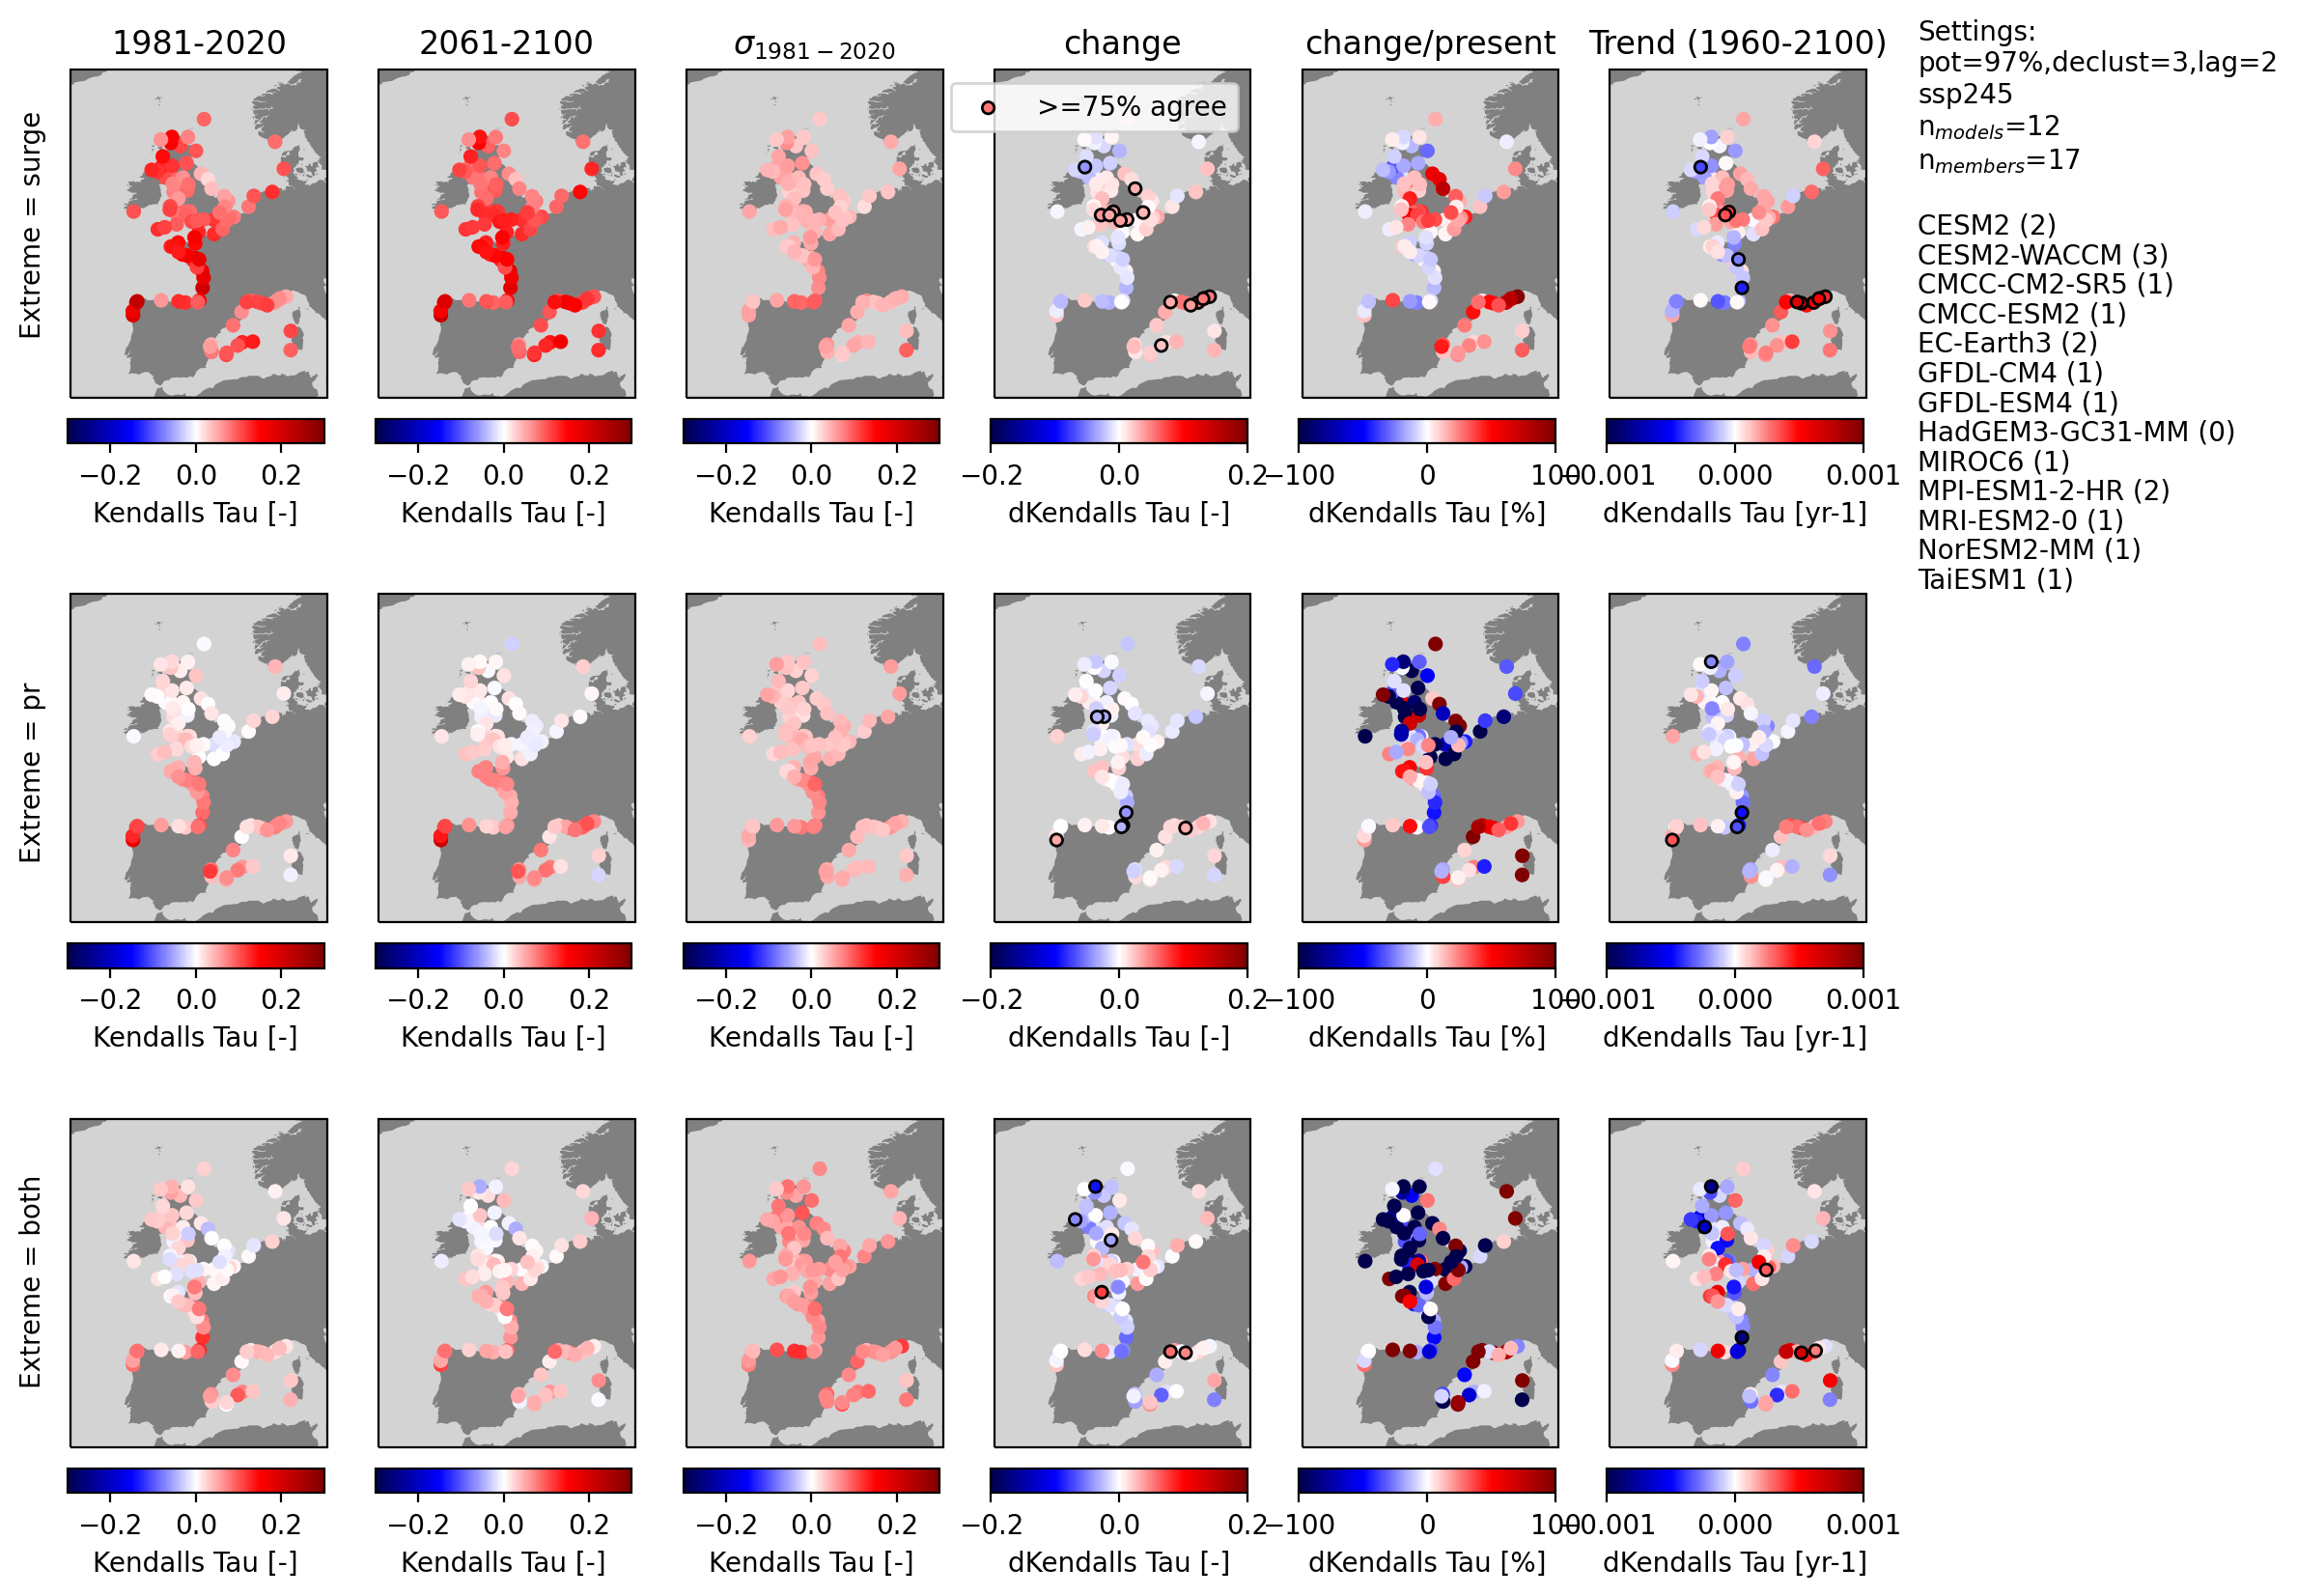

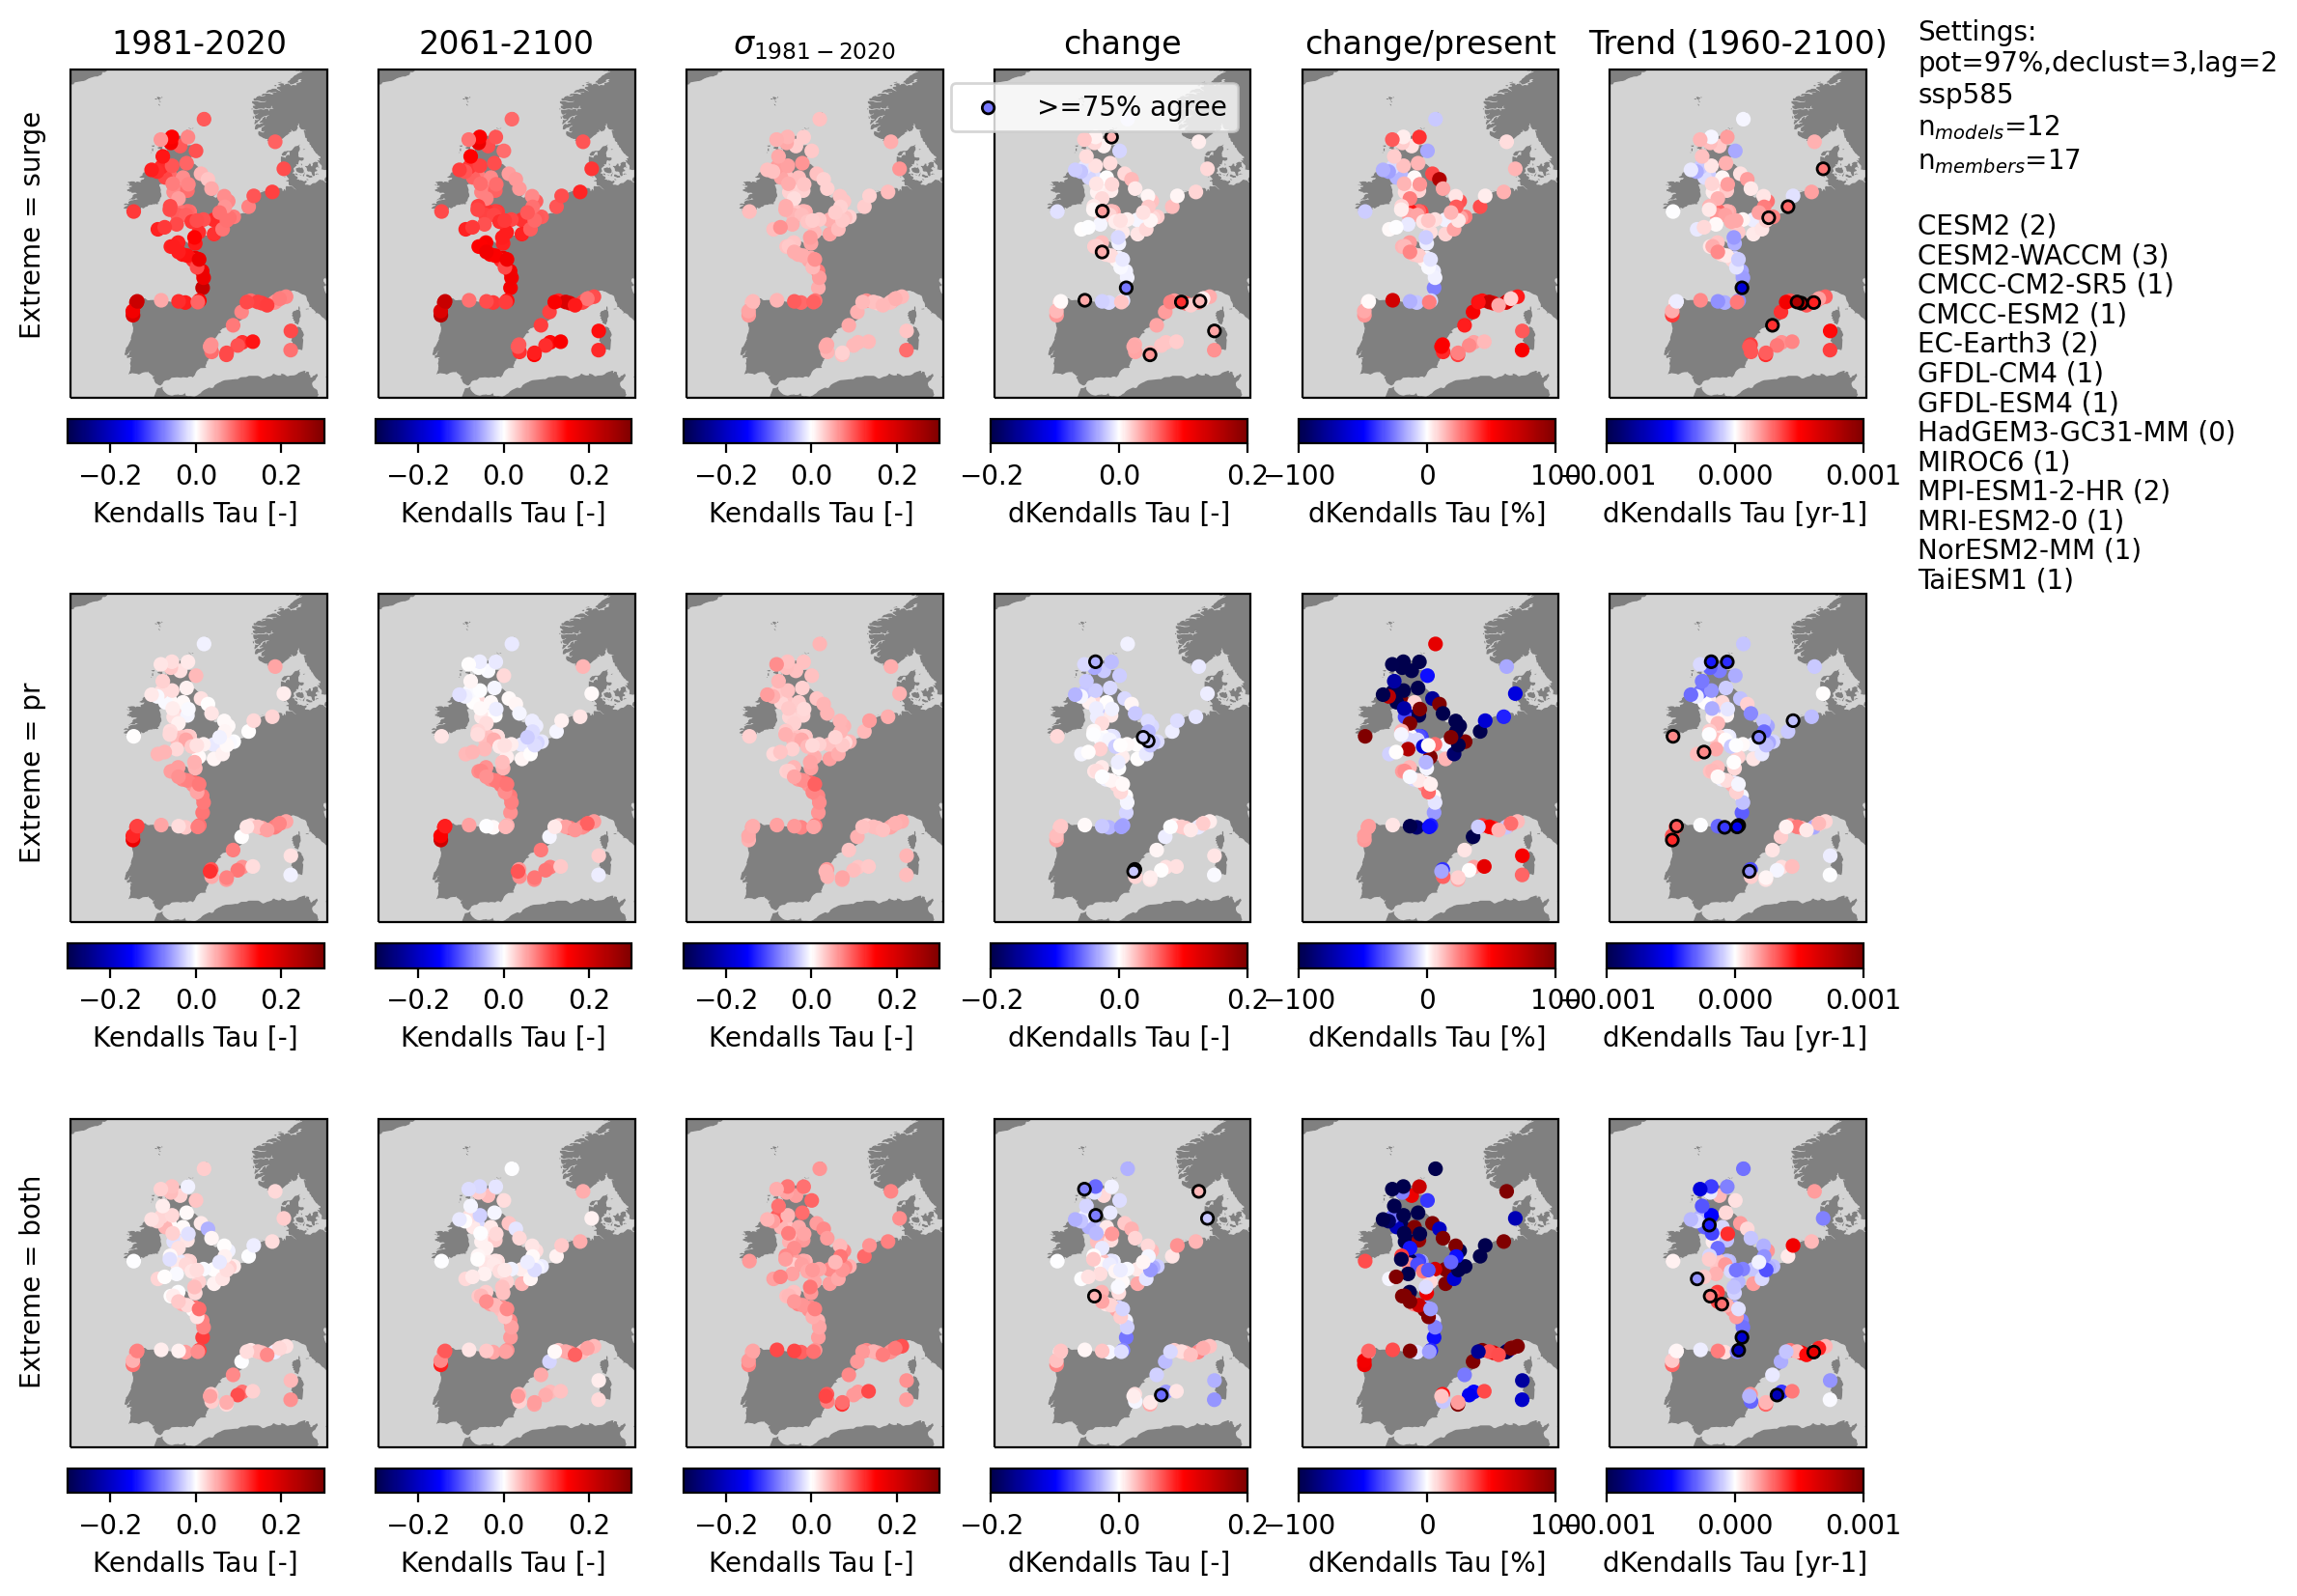

In [6]:
for ssp in ssps:
    ssp_ds = ds_intersect.sel(ssp=ssp)

    ssp_ds_present = ssp_ds.sel(window=2000)#ssp_ds.sel(window=2000)
    ssp_ds_future = ssp_ds.sel(window=2080)
    ssp_ds_diff = ssp_ds_future - ssp_ds_present

    fig=plt.figure(figsize=(12,10)) #generate figure  
    gs = fig.add_gridspec(3,6)

    for v,variate in enumerate(ssp_ds_present.extreme_variate.values):

        #1991-2020
        ax = plt.subplot(gs[v,0],projection=ccrs.Robinson(central_longitude=0))

        ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
        ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

        sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=ssp_ds_present.ktau.sel(statistic='coef',extreme_variate=variate).mean(dim='member_id').mean(dim='source_id'),cmap='seismic',vmin=-.3,vmax=.3,s=20,transform=ccrs.PlateCarree(),zorder=3)
        ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Kendalls Tau [-]')
        if v==0:
            ax.set_title('1981-2020')

        ax.annotate('Extreme = '+variate,(-.2,.2),xycoords='axes fraction',rotation=90)

        #2071-2100
        ax = plt.subplot(gs[v,1],projection=ccrs.Robinson(central_longitude=0))

        ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
        ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

        sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=ssp_ds_future.ktau.sel(statistic='coef',extreme_variate=variate).mean(dim='member_id').mean(dim='source_id'),cmap='seismic',vmin=-.3,vmax=.3,s=20,transform=ccrs.PlateCarree(),zorder=3)
        ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Kendalls Tau [-]')
        if v==0:
            ax.set_title('2061-2100')

        #standard present      
        ax = plt.subplot(gs[v,2],projection=ccrs.Robinson(central_longitude=0))

        ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
        ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

        sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=ssp_ds_present.ktau.sel(statistic='coef',extreme_variate=variate).mean(dim='member_id').std(dim='source_id'),cmap='seismic',vmin=-.3,vmax=.3,s=20,transform=ccrs.PlateCarree(),zorder=3)
        ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Kendalls Tau [-]')
        if v==0:
            ax.set_title('$\sigma_{1981-2020}$')

        #change
        ax = plt.subplot(gs[v,3],projection=ccrs.Robinson(central_longitude=0))

        ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
        ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

        diff = ssp_ds_diff.ktau.sel(statistic='coef',extreme_variate=variate).mean(dim='member_id')
        ens_diff = ssp_ds_diff.ktau.sel(statistic='coef',extreme_variate=variate).mean(dim='member_id').mean(dim='source_id')

        num_agree = ((diff*ens_diff)>0).sum(dim='source_id')
        fraction_exceeds = (num_agree>=.75*len(diff.source_id))

        sc=ax.scatter(ssp_ds.lon[fraction_exceeds],ssp_ds.lat[fraction_exceeds],c=ens_diff[fraction_exceeds],cmap='seismic',edgecolor='black',vmin=-.2,vmax=.2,s=20,transform=ccrs.PlateCarree(),zorder=3,label='>=75% agree')
        sc=ax.scatter(ssp_ds.lon[~fraction_exceeds],ssp_ds.lat[~fraction_exceeds],c=ens_diff[~fraction_exceeds],cmap='seismic',vmin=-.2,vmax=.2,s=20,transform=ccrs.PlateCarree(),zorder=2)

        if v==0:
            ax.legend()

        ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='dKendalls Tau [-]')
        if v==0:
            ax.set_title('change')


        #%change
        ax = plt.subplot(gs[v,4],projection=ccrs.Robinson(central_longitude=0))

        ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
        ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

        sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=100*ssp_ds_diff.ktau.sel(statistic='coef',extreme_variate=variate).mean(dim='member_id').mean(dim='source_id')/ssp_ds_present.ktau.sel(statistic='coef',extreme_variate=variate).mean(dim='member_id').mean(dim='source_id'),cmap='seismic',vmin=-100,vmax=100,s=20,transform=ccrs.PlateCarree(),zorder=3)
        ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='dKendalls Tau [%]')
        if v==0:
            ax.set_title('change/present')

        #standard dev change       
        ax = plt.subplot(gs[v,5],projection=ccrs.Robinson(central_longitude=0))

        ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
        ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')
        
        
        
        slope = ssp_ds.ktau_slope.sel(statistic='coef',extreme_variate=variate).mean(dim='member_id')
        ens_slope = ssp_ds.ktau_slope.sel(statistic='coef',extreme_variate=variate).mean(dim='member_id').mean(dim='source_id')

        num_agree = ((slope*ens_slope)>0).sum(dim='source_id')
        fraction_exceeds = (num_agree>=.75*len(slope.source_id))

        sc=ax.scatter(ssp_ds.lon[fraction_exceeds],ssp_ds.lat[fraction_exceeds],c=ens_slope[fraction_exceeds],cmap='seismic',edgecolor='black',vmin=-.001,vmax=.001,s=20,transform=ccrs.PlateCarree(),zorder=3,label='>=75% agree')
        sc=ax.scatter(ssp_ds.lon[~fraction_exceeds],ssp_ds.lat[~fraction_exceeds],c=ens_slope[~fraction_exceeds],cmap='seismic',vmin=-.001,vmax=.001,s=20,transform=ccrs.PlateCarree(),zorder=2)

        #sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=ssp_ds.ktau_slope.sel(statistic='coef',extreme_variate=variate).mean(dim='member_id').mean(dim='source_id'),cmap='seismic',vmin=-.05,vmax=.05,s=20,transform=ccrs.PlateCarree(),zorder=3)
        #sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=ssp_ds_diff.ktau.sel(statistic='coef',extreme_variate=variate).mean(dim='member_id').std(dim='source_id'),cmap='seismic',vmin=-.2,vmax=.2,s=20,transform=ccrs.PlateCarree(),zorder=3)
        ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='dKendalls Tau [yr-1]')
        if v==0:
            #ax.set_title('$\sigma_{change}$')
            ax.set_title('Trend (1960-2100)')
            n_models = np.sum(np.isfinite(ssp_ds_diff.isel(tg=0,extreme_variate=0,statistic=0).ktau).sum(dim='member_id')>0).values
            n_members = np.sum(np.isfinite(ssp_ds_diff.isel(tg=0,extreme_variate=0,statistic=0).ktau).sum(dim='member_id')).values
            ax.annotate('Settings:\npot=97%,declust=3,lag=2\n'+str(ssp)+'\nn$_{models}$='+str(n_models)+'\nn$_{members}$='+str(n_members),(1.2,.7),xycoords='axes fraction')
            list_models_members = [s+' ('+str(k)+')' for s,k in zip(ssp_ds_diff.source_id.values,np.isfinite(ssp_ds_diff.isel(tg=0,extreme_variate=0,statistic=0).ktau).sum(dim='member_id').values)]
            for m,model in enumerate(list_models_members):
                ax.annotate(model,(1.2,.5-m*.09),xycoords='axes fraction')

Using all data in each ssp (less easy to compare between scenarios)

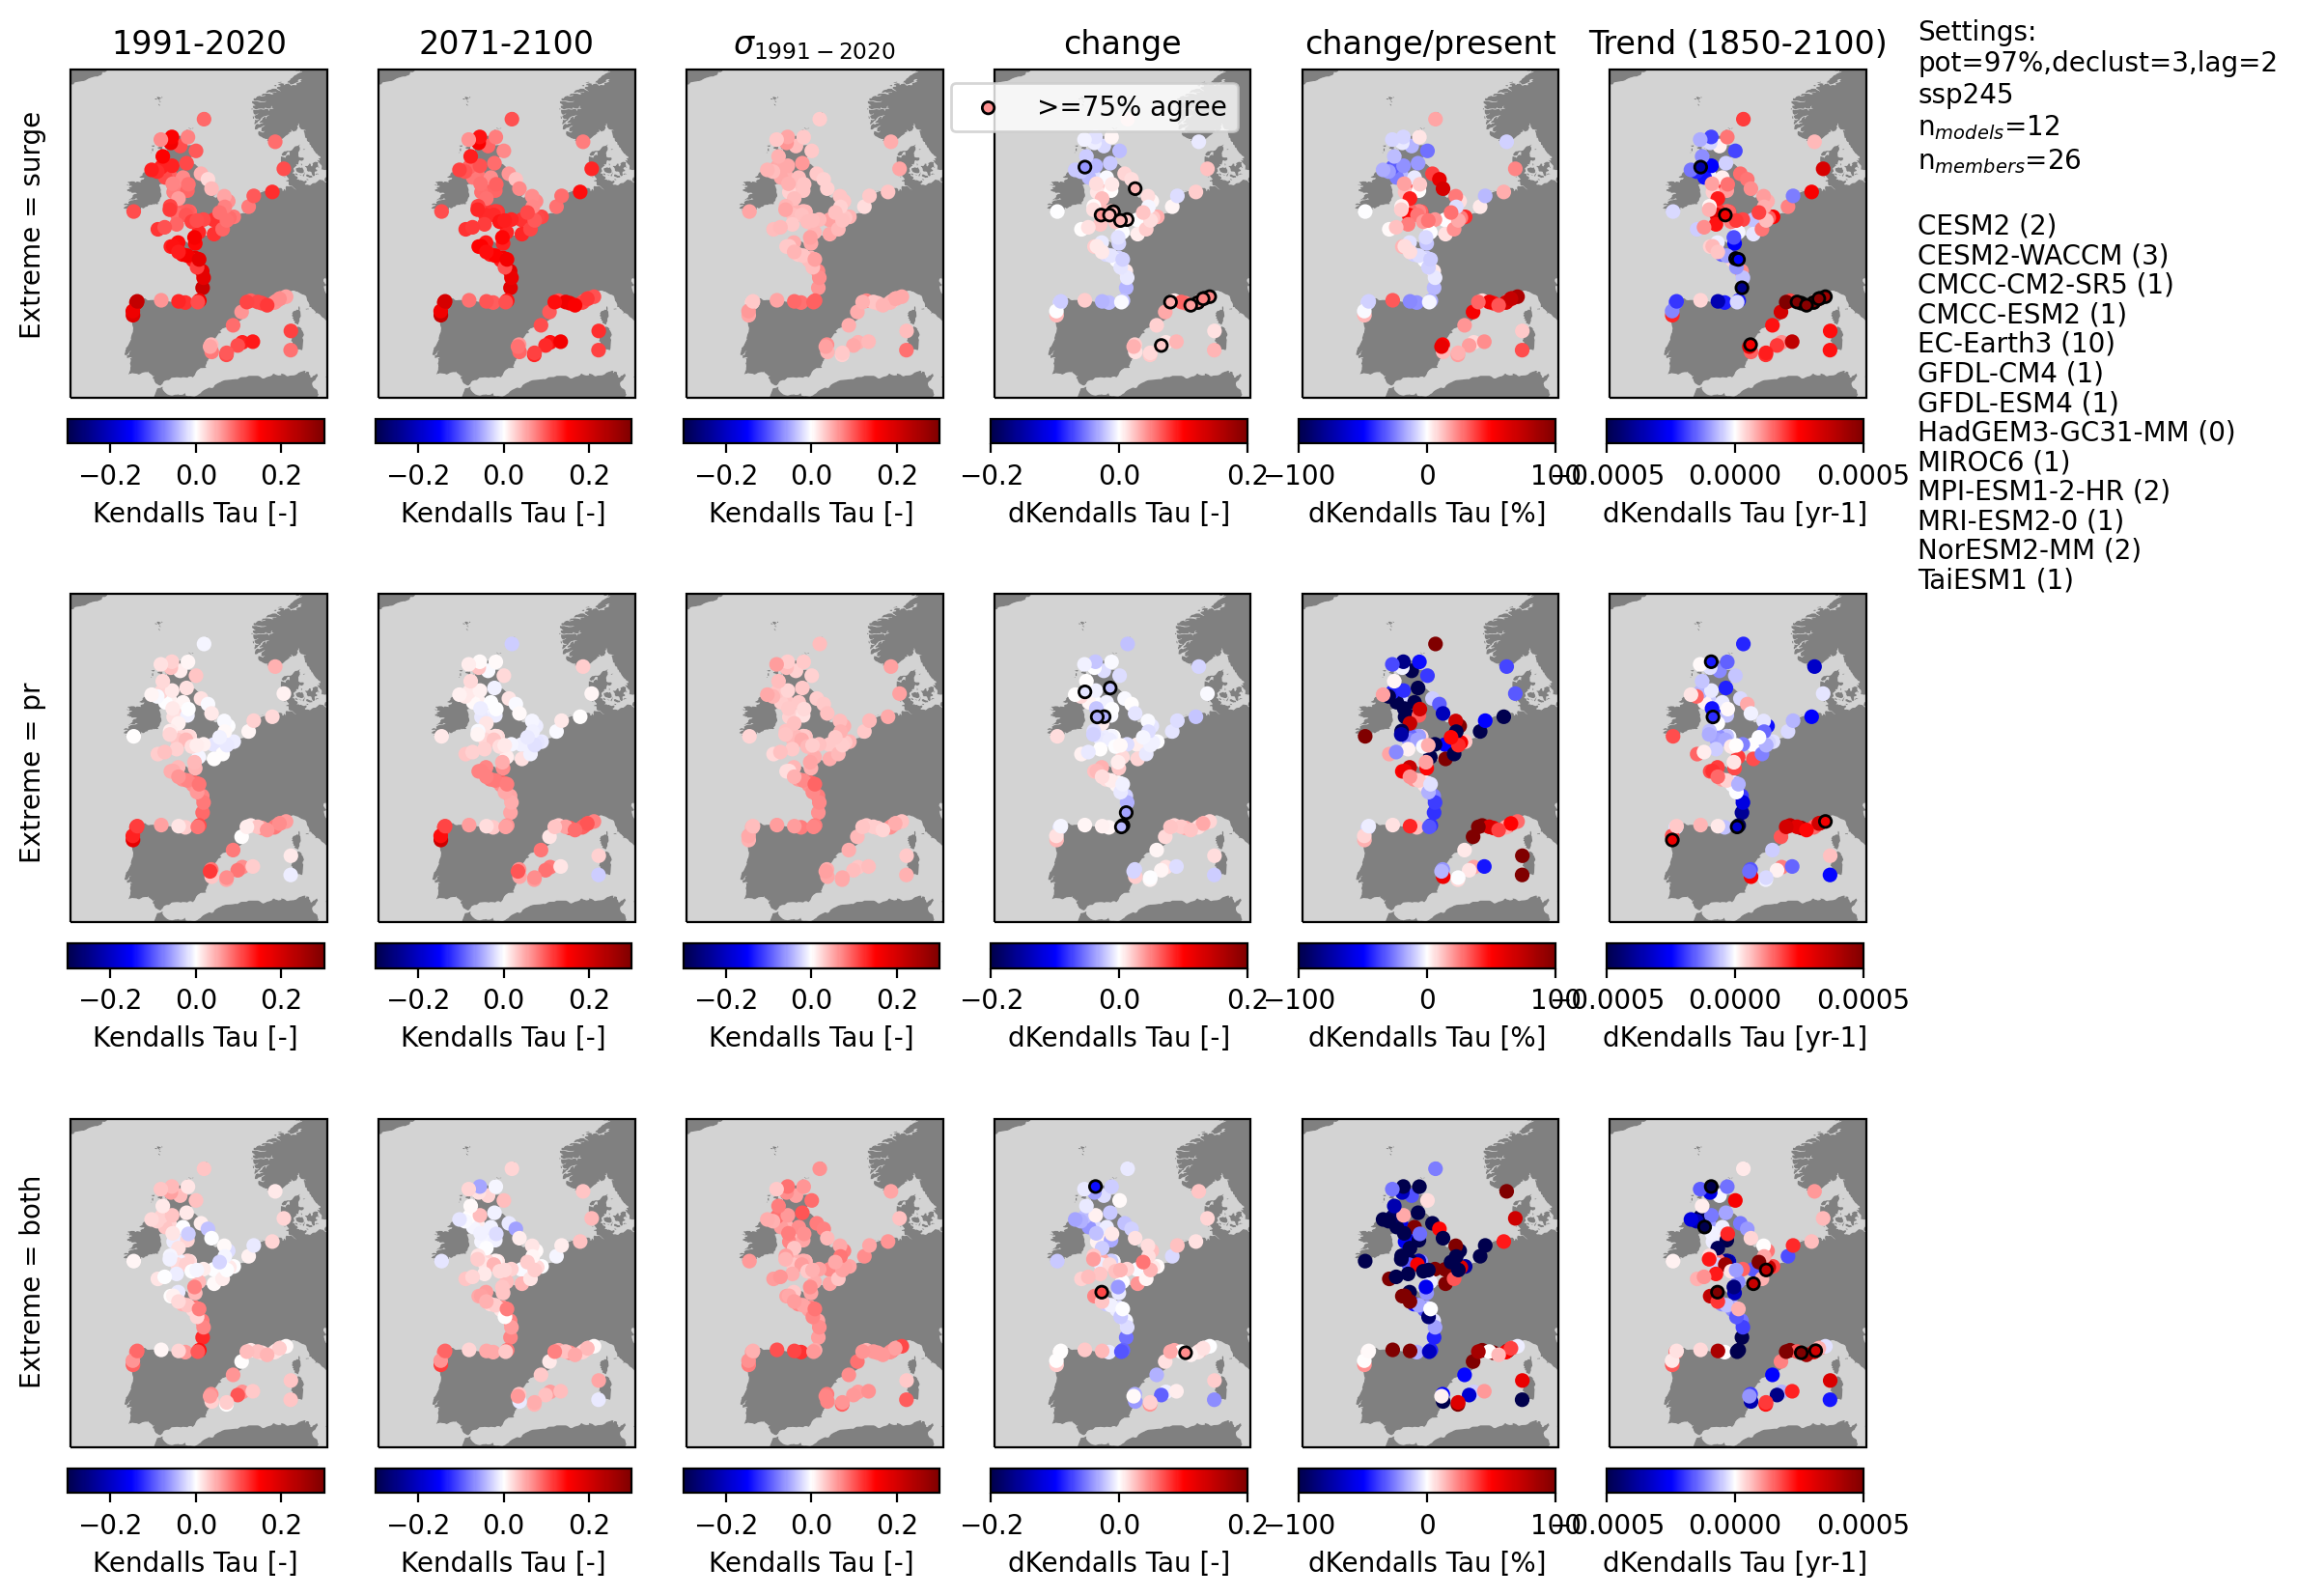

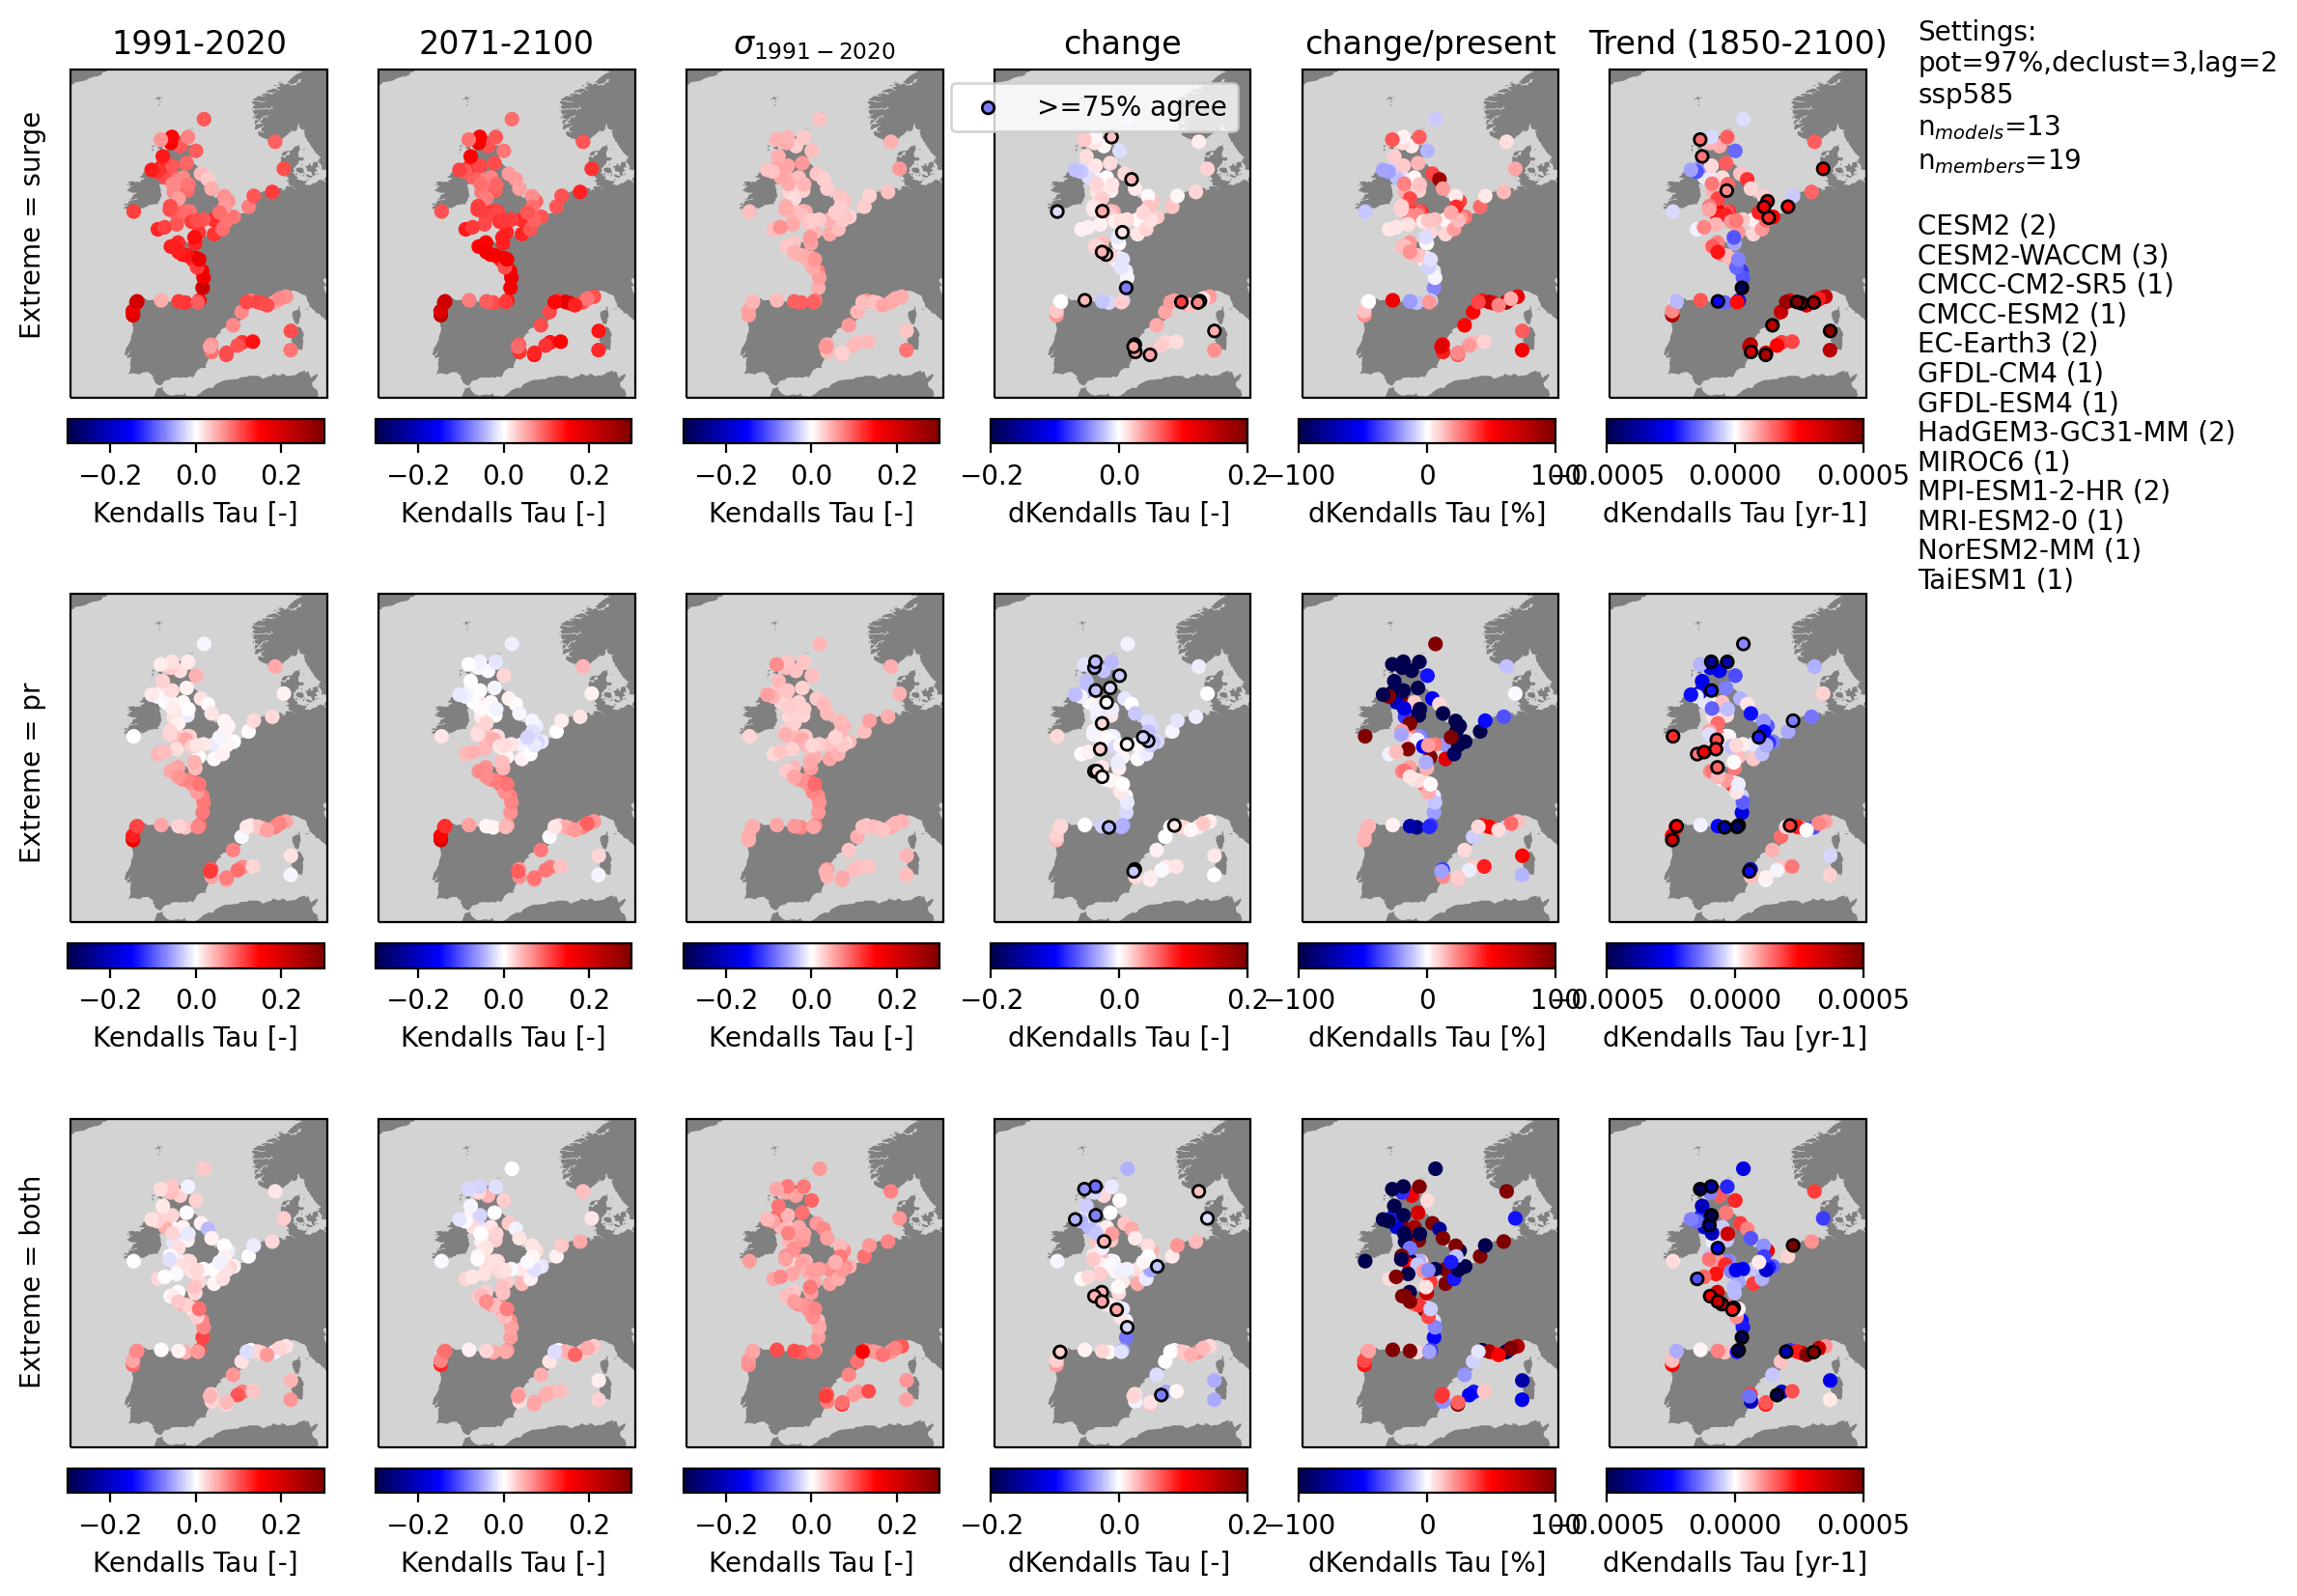

In [7]:
for ssp in ssps:
    ssp_ds = ds.sel(ssp=ssp)

    ssp_ds_present = ssp_ds.sel(window=2000)
    ssp_ds_future = ssp_ds.sel(window=2080)
    ssp_ds_diff = ssp_ds_future - ssp_ds_present

    fig=plt.figure(figsize=(12,10)) #generate figure  
    gs = fig.add_gridspec(3,6)

    for v,variate in enumerate(ssp_ds_present.extreme_variate.values):

        #1991-2020
        ax = plt.subplot(gs[v,0],projection=ccrs.Robinson(central_longitude=0))

        ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
        ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

        sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=ssp_ds_present.ktau.sel(statistic='coef',extreme_variate=variate).mean(dim='member_id').mean(dim='source_id'),cmap='seismic',vmin=-.3,vmax=.3,s=20,transform=ccrs.PlateCarree(),zorder=3)
        ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Kendalls Tau [-]')
        if v==0:
            ax.set_title('1991-2020')

        ax.annotate('Extreme = '+variate,(-.2,.2),xycoords='axes fraction',rotation=90)

        #2071-2100
        ax = plt.subplot(gs[v,1],projection=ccrs.Robinson(central_longitude=0))

        ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
        ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

        sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=ssp_ds_future.ktau.sel(statistic='coef',extreme_variate=variate).mean(dim='member_id').mean(dim='source_id'),cmap='seismic',vmin=-.3,vmax=.3,s=20,transform=ccrs.PlateCarree(),zorder=3)
        ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Kendalls Tau [-]')
        if v==0:
            ax.set_title('2071-2100')

        #standard present      
        ax = plt.subplot(gs[v,2],projection=ccrs.Robinson(central_longitude=0))

        ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
        ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

        sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=ssp_ds_present.ktau.sel(statistic='coef',extreme_variate=variate).mean(dim='member_id').std(dim='source_id'),cmap='seismic',vmin=-.3,vmax=.3,s=20,transform=ccrs.PlateCarree(),zorder=3)
        ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Kendalls Tau [-]')
        if v==0:
            ax.set_title('$\sigma_{1991-2020}$')

        #change
        ax = plt.subplot(gs[v,3],projection=ccrs.Robinson(central_longitude=0))

        ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
        ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

        diff = ssp_ds_diff.ktau.sel(statistic='coef',extreme_variate=variate).mean(dim='member_id')
        ens_diff = ssp_ds_diff.ktau.sel(statistic='coef',extreme_variate=variate).mean(dim='member_id').mean(dim='source_id')

        num_agree = ((diff*ens_diff)>0).sum(dim='source_id')
        fraction_exceeds = (num_agree>=.75*len(diff.source_id))

        sc=ax.scatter(ssp_ds.lon[fraction_exceeds],ssp_ds.lat[fraction_exceeds],c=ens_diff[fraction_exceeds],cmap='seismic',edgecolor='black',vmin=-.2,vmax=.2,s=20,transform=ccrs.PlateCarree(),zorder=3,label='>=75% agree')
        sc=ax.scatter(ssp_ds.lon[~fraction_exceeds],ssp_ds.lat[~fraction_exceeds],c=ens_diff[~fraction_exceeds],cmap='seismic',vmin=-.2,vmax=.2,s=20,transform=ccrs.PlateCarree(),zorder=2)

        if v==0:
            ax.legend()

        ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='dKendalls Tau [-]')
        if v==0:
            ax.set_title('change')


        #%change
        ax = plt.subplot(gs[v,4],projection=ccrs.Robinson(central_longitude=0))

        ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
        ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

        sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=100*ssp_ds_diff.ktau.sel(statistic='coef',extreme_variate=variate).mean(dim='member_id').mean(dim='source_id')/ssp_ds_present.ktau.sel(statistic='coef',extreme_variate=variate).mean(dim='member_id').mean(dim='source_id'),cmap='seismic',vmin=-100,vmax=100,s=20,transform=ccrs.PlateCarree(),zorder=3)
        ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='dKendalls Tau [%]')
        if v==0:
            ax.set_title('change/present')

        #standard dev change       
        ax = plt.subplot(gs[v,5],projection=ccrs.Robinson(central_longitude=0))

        ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
        ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')
        
        
        
        slope = ssp_ds.ktau_slope.sel(statistic='coef',extreme_variate=variate).mean(dim='member_id')
        ens_slope = ssp_ds.ktau_slope.sel(statistic='coef',extreme_variate=variate).mean(dim='member_id').mean(dim='source_id')

        num_agree = ((slope*ens_slope)>0).sum(dim='source_id')
        fraction_exceeds = (num_agree>=.75*len(slope.source_id))

        sc=ax.scatter(ssp_ds.lon[fraction_exceeds],ssp_ds.lat[fraction_exceeds],c=ens_slope[fraction_exceeds],cmap='seismic',edgecolor='black',vmin=-.0005,vmax=.0005,s=20,transform=ccrs.PlateCarree(),zorder=3,label='>=75% agree')
        sc=ax.scatter(ssp_ds.lon[~fraction_exceeds],ssp_ds.lat[~fraction_exceeds],c=ens_slope[~fraction_exceeds],cmap='seismic',vmin=-.0005,vmax=.0005,s=20,transform=ccrs.PlateCarree(),zorder=2)

        #sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=ssp_ds.ktau_slope.sel(statistic='coef',extreme_variate=variate).mean(dim='member_id').mean(dim='source_id'),cmap='seismic',vmin=-.05,vmax=.05,s=20,transform=ccrs.PlateCarree(),zorder=3)
        #sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=ssp_ds_diff.ktau.sel(statistic='coef',extreme_variate=variate).mean(dim='member_id').std(dim='source_id'),cmap='seismic',vmin=-.2,vmax=.2,s=20,transform=ccrs.PlateCarree(),zorder=3)
        ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='dKendalls Tau [yr-1]')
        if v==0:
            #ax.set_title('$\sigma_{change}$')
            ax.set_title('Trend (1850-2100)')
            n_models = np.sum(np.isfinite(ssp_ds_diff.isel(tg=0,extreme_variate=0,statistic=0).ktau).sum(dim='member_id')>0).values
            n_members = np.sum(np.isfinite(ssp_ds_diff.isel(tg=0,extreme_variate=0,statistic=0).ktau).sum(dim='member_id')).values
            ax.annotate('Settings:\npot=97%,declust=3,lag=2\n'+str(ssp)+'\nn$_{models}$='+str(n_models)+'\nn$_{members}$='+str(n_members),(1.2,.7),xycoords='axes fraction')
            list_models_members = [s+' ('+str(k)+')' for s,k in zip(ssp_ds_diff.source_id.values,np.isfinite(ssp_ds_diff.isel(tg=0,extreme_variate=0,statistic=0).ktau).sum(dim='member_id').values)]
            for m,model in enumerate(list_models_members):
                ax.annotate(model,(1.2,.5-m*.09),xycoords='axes fraction')

**Ensemble mean's UTDC**

Intersection

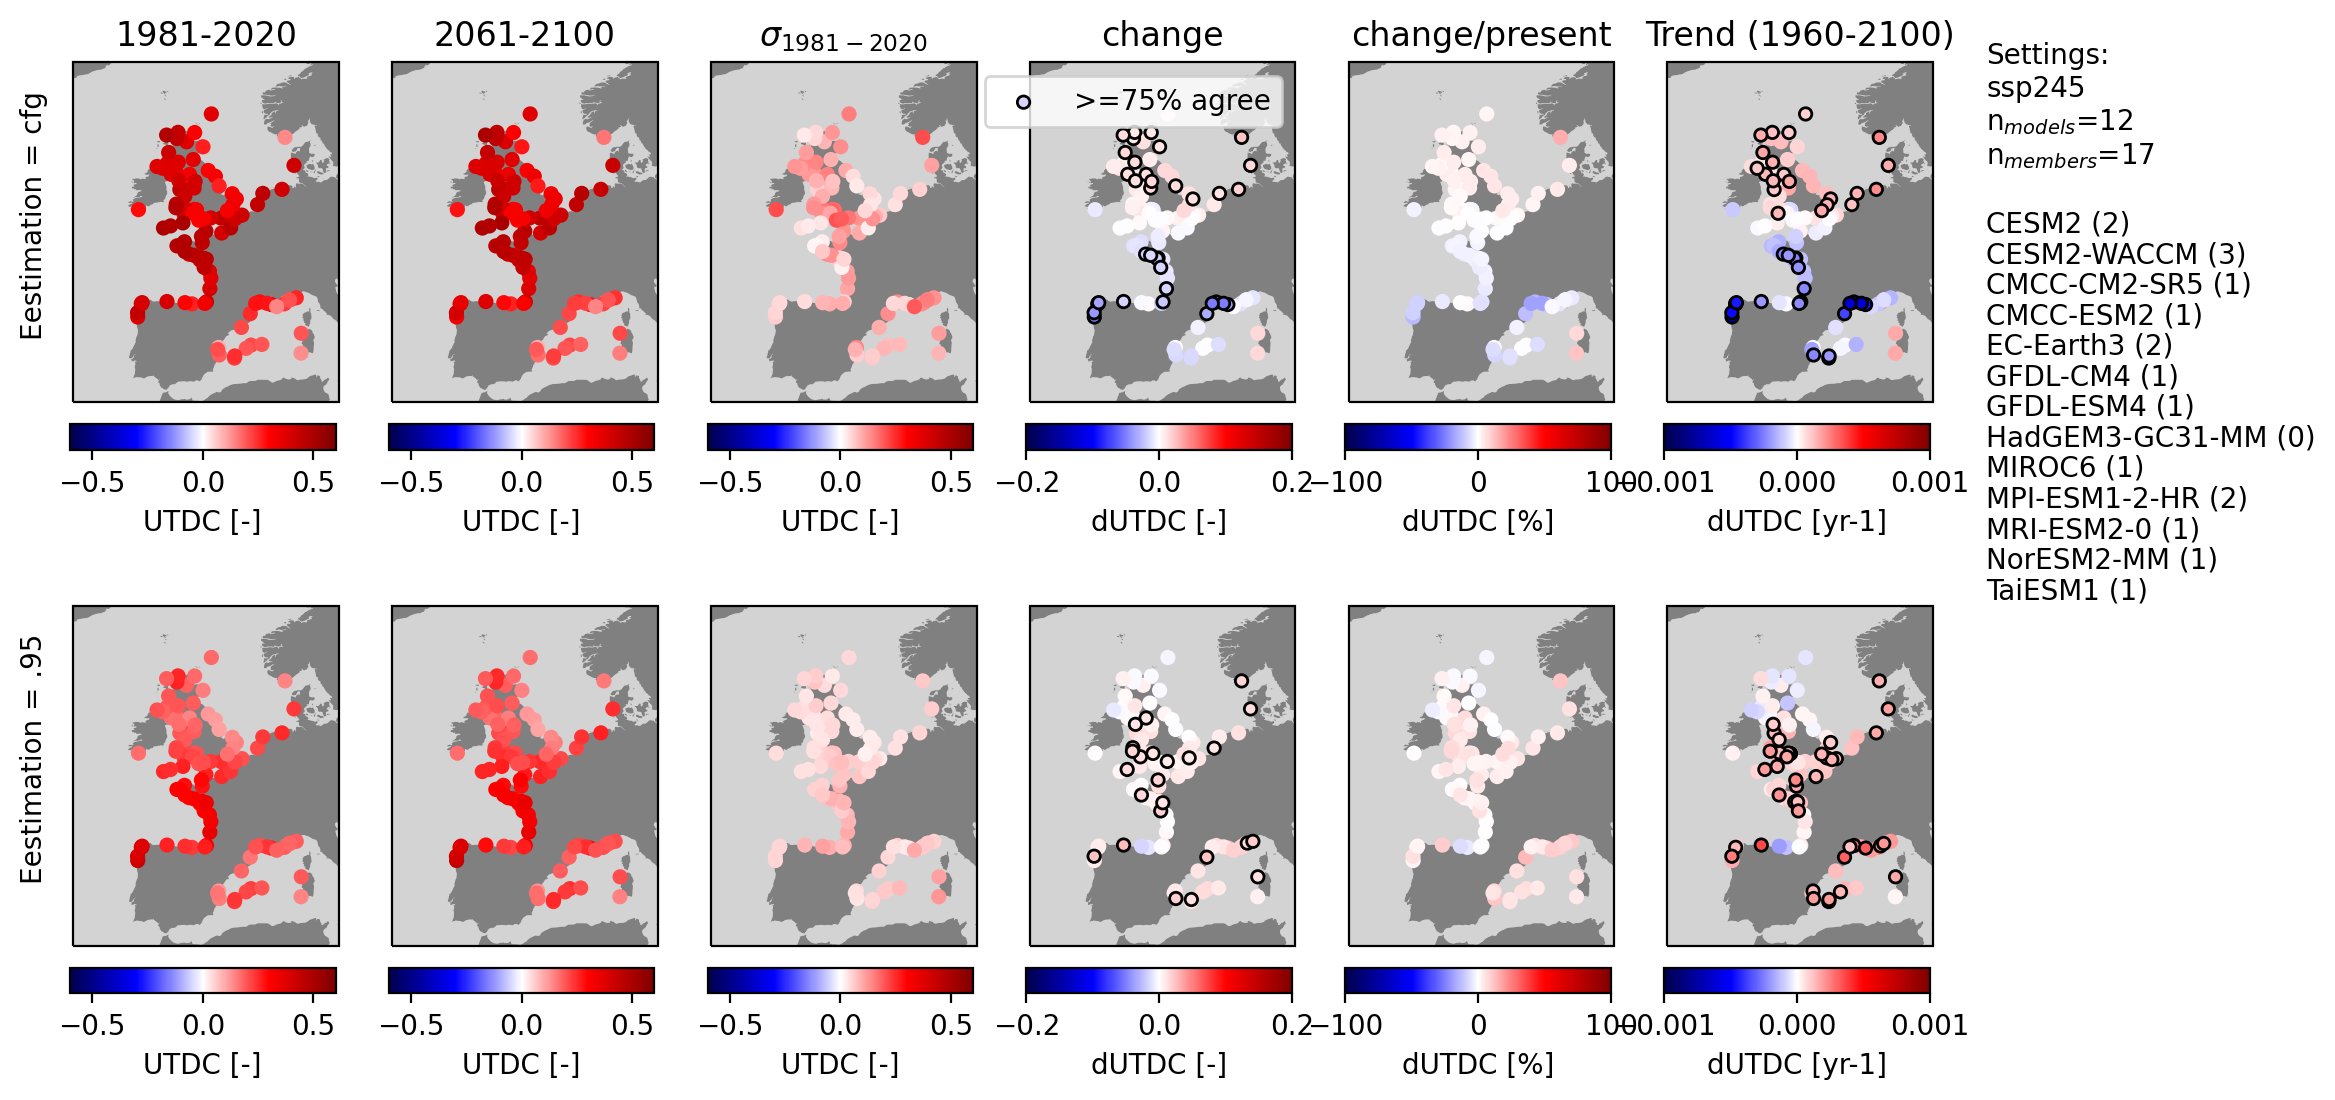

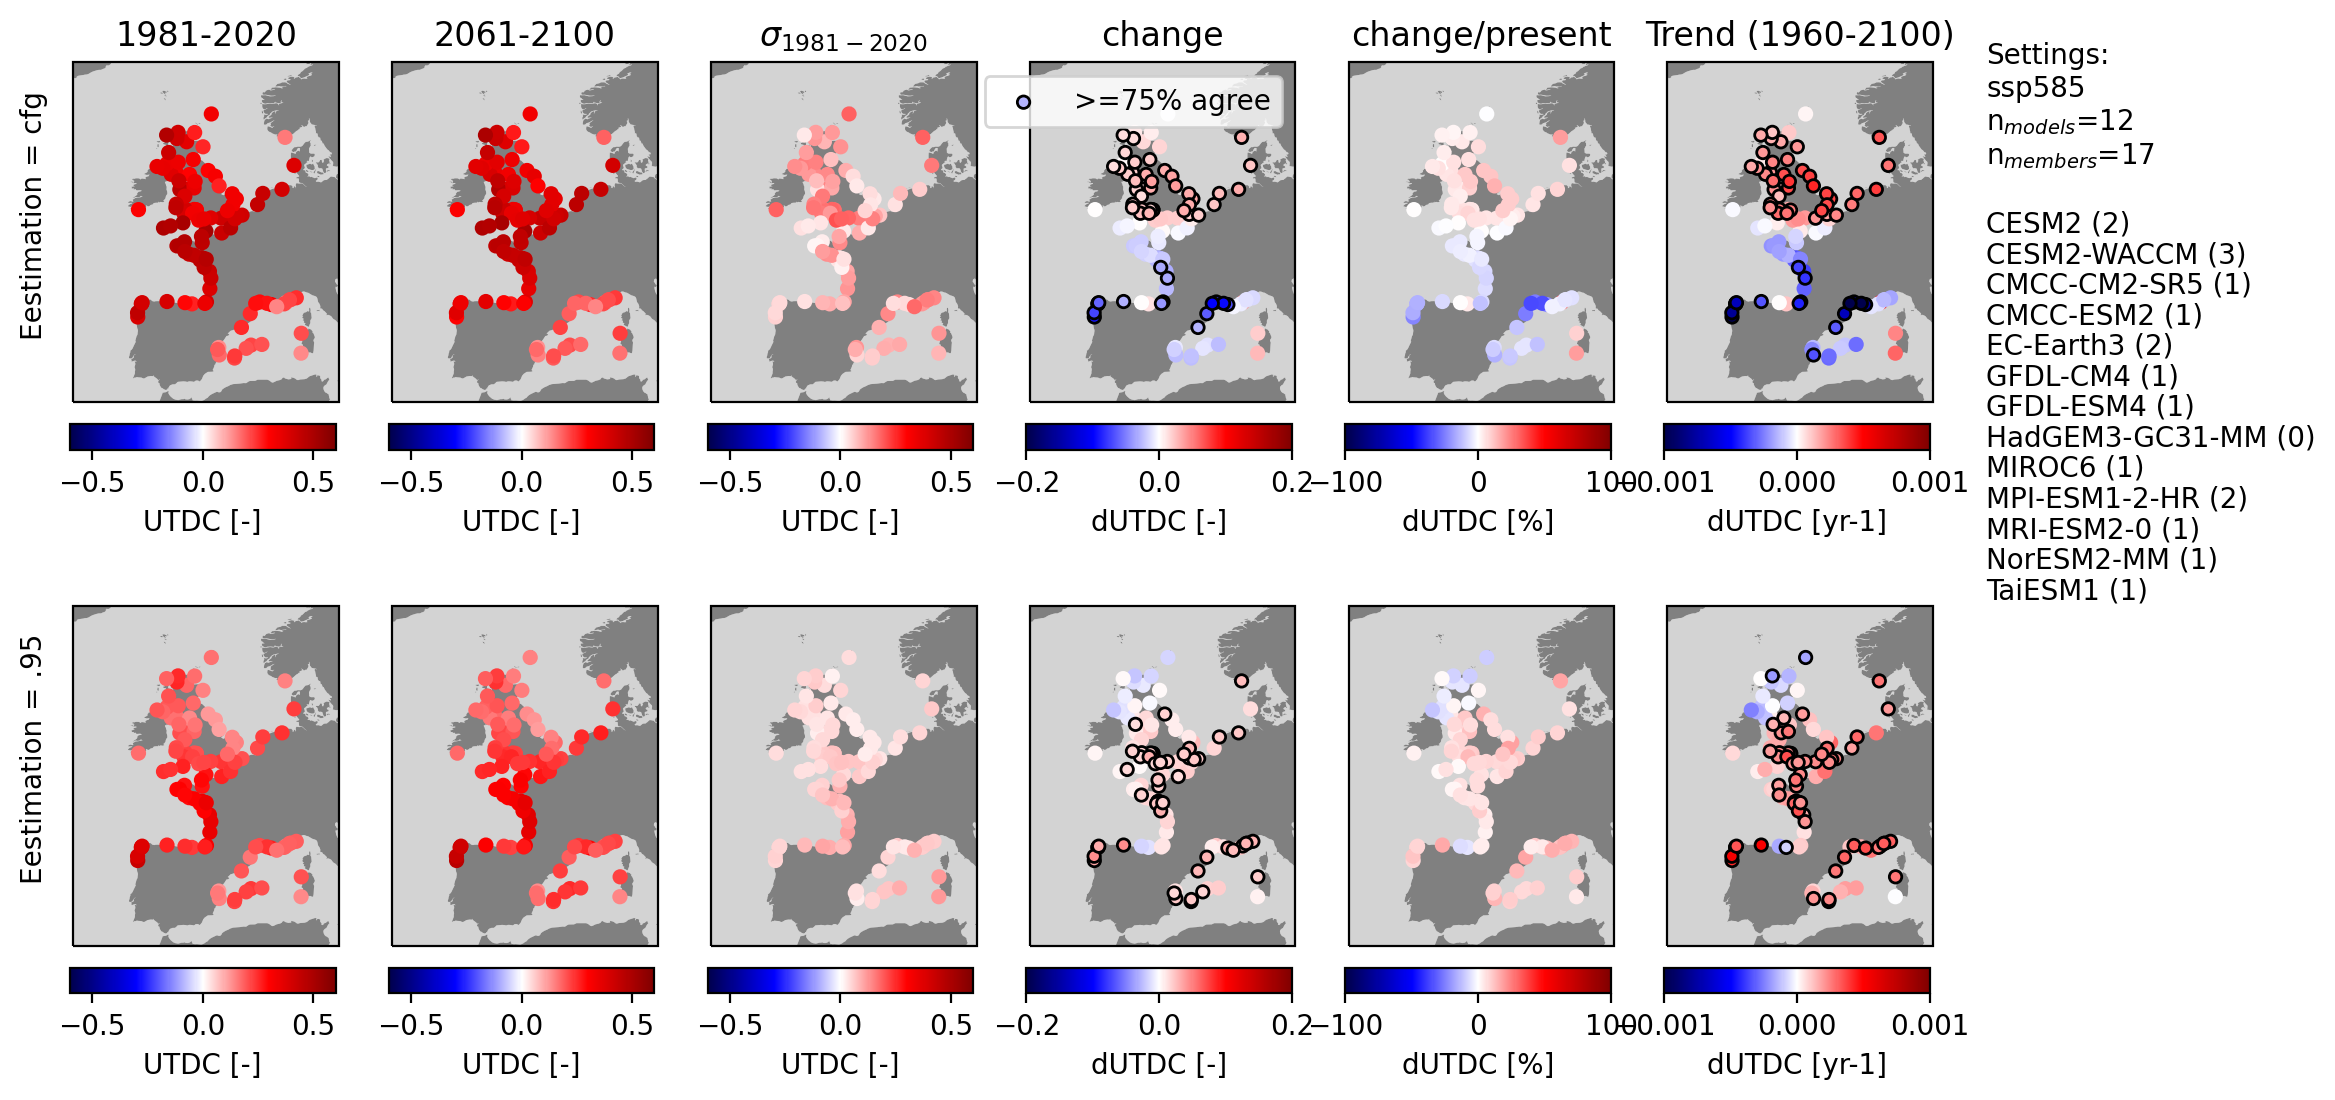

In [8]:
for ssp in ssps:
    ssp_ds = ds_intersect.sel(ssp=ssp)

    ssp_ds_present = ssp_ds.sel(window=2000)#.sel(window=2005)
    ssp_ds_future = ssp_ds.sel(window=2080)#.sel(window=2085)
    ssp_ds_diff = ssp_ds_future - ssp_ds_present

    fig=plt.figure(figsize=(12,10)) #generate figure  
    gs = fig.add_gridspec(3,6)

    for e,method in enumerate(ssp_ds_present.estimator.values):

        #1991-2020
        ax = plt.subplot(gs[e,0],projection=ccrs.Robinson(central_longitude=0))

        ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
        ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

        sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=ssp_ds_present.utdc.sel(statistic='coef',estimator=method).mean(dim='member_id').mean(dim='source_id'),cmap='seismic',vmin=-.6,vmax=.6,s=20,transform=ccrs.PlateCarree(),zorder=3)
        ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='UTDC [-]')
        if e==0:
            ax.set_title('1981-2020')

        ax.annotate('Eestimation = '+method,(-.2,.2),xycoords='axes fraction',rotation=90)

        #2071-2100
        ax = plt.subplot(gs[e,1],projection=ccrs.Robinson(central_longitude=0))

        ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
        ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

        sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=ssp_ds_future.utdc.sel(statistic='coef',estimator=method).mean(dim='member_id').mean(dim='source_id'),cmap='seismic',vmin=-.6,vmax=.6,s=20,transform=ccrs.PlateCarree(),zorder=3)
        ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='UTDC [-]')
        if e==0:
            ax.set_title('2061-2100')

        #standard present      
        ax = plt.subplot(gs[e,2],projection=ccrs.Robinson(central_longitude=0))

        ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
        ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

        sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=ssp_ds_present.utdc.sel(statistic='coef',estimator=method).mean(dim='member_id').std(dim='source_id'),cmap='seismic',vmin=-.6,vmax=.6,s=20,transform=ccrs.PlateCarree(),zorder=3)
        ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='UTDC [-]')
        if e==0:
            ax.set_title('$\sigma_{1981-2020}$')

        #change
        ax = plt.subplot(gs[e,3],projection=ccrs.Robinson(central_longitude=0))

        ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
        ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

        diff = ssp_ds_diff.utdc.sel(statistic='coef',estimator=method).mean(dim='member_id')
        ens_diff = ssp_ds_diff.utdc.sel(statistic='coef',estimator=method).mean(dim='member_id').mean(dim='source_id')

        num_agree = ((diff*ens_diff)>0).sum(dim='source_id')
        fraction_exceeds = (num_agree>=.75*len(diff.source_id))

        sc=ax.scatter(ssp_ds.lon[fraction_exceeds],ssp_ds.lat[fraction_exceeds],c=ens_diff[fraction_exceeds],cmap='seismic',edgecolor='black',vmin=-.2,vmax=.2,s=20,transform=ccrs.PlateCarree(),zorder=3,label='>=75% agree')
        sc=ax.scatter(ssp_ds.lon[~fraction_exceeds],ssp_ds.lat[~fraction_exceeds],c=ens_diff[~fraction_exceeds],cmap='seismic',vmin=-.2,vmax=.2,s=20,transform=ccrs.PlateCarree(),zorder=2)

        if e==0:
            ax.legend()

        ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='dUTDC [-]')
        if e==0:
            ax.set_title('change')


        #%change
        ax = plt.subplot(gs[e,4],projection=ccrs.Robinson(central_longitude=0))

        ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
        ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

        sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=100*ssp_ds_diff.utdc.sel(statistic='coef',estimator=method).mean(dim='member_id').mean(dim='source_id')/ssp_ds_present.utdc.sel(statistic='coef',estimator=method).mean(dim='member_id').mean(dim='source_id'),cmap='seismic',vmin=-100,vmax=100,s=20,transform=ccrs.PlateCarree(),zorder=3)
        ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='dUTDC [%]')
        if e==0:
            ax.set_title('change/present')

        #standard dev change       
        ax = plt.subplot(gs[e,5],projection=ccrs.Robinson(central_longitude=0))

        ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
        ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')
        
        
        slope = ssp_ds.utdc_slope.sel(statistic='coef',estimator=method).mean(dim='member_id')
        ens_slope = ssp_ds.utdc_slope.sel(statistic='coef',estimator=method).mean(dim='member_id').mean(dim='source_id')

        num_agree = ((slope*ens_slope)>0).sum(dim='source_id')
        fraction_exceeds = (num_agree>=.75*len(slope.source_id))

        sc=ax.scatter(ssp_ds.lon[fraction_exceeds],ssp_ds.lat[fraction_exceeds],c=ens_slope[fraction_exceeds],cmap='seismic',edgecolor='black',vmin=-.001,vmax=.001,s=20,transform=ccrs.PlateCarree(),zorder=3,label='>=75% agree')
        sc=ax.scatter(ssp_ds.lon[~fraction_exceeds],ssp_ds.lat[~fraction_exceeds],c=ens_slope[~fraction_exceeds],cmap='seismic',vmin=-.001,vmax=.001,s=20,transform=ccrs.PlateCarree(),zorder=2)

        
        
        #sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=ssp_ds_diff.utdc.sel(statistic='coef',estimator=method).mean(dim='member_id').std(dim='source_id'),cmap='seismic',vmin=-.2,vmax=.2,s=20,transform=ccrs.PlateCarree(),zorder=3)
        ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='dUTDC [yr-1]')
        if e==0:
            #ax.set_title('$\sigma_{change}$')
            ax.set_title('Trend (1960-2100)')
            n_models = np.sum(np.isfinite(ssp_ds_diff.isel(tg=0,estimator=0,statistic=0).utdc).sum(dim='member_id')>0).values
            n_members = np.sum(np.isfinite(ssp_ds_diff.isel(tg=0,estimator=0,statistic=0).utdc).sum(dim='member_id')).values
            ax.annotate('Settings:\n'+str(ssp)+'\nn$_{models}$='+str(n_models)+'\nn$_{members}$='+str(n_members),(1.2,.7),xycoords='axes fraction')
            list_models_members = [s+' ('+str(k)+')' for s,k in zip(ssp_ds_diff.source_id.values,np.isfinite(ssp_ds_diff.isel(tg=0,estimator=0,statistic=0).utdc).sum(dim='member_id').values)]
            for m,model in enumerate(list_models_members):
                ax.annotate(model,(1.2,.5-m*.09),xycoords='axes fraction')


Using all data per ssp:

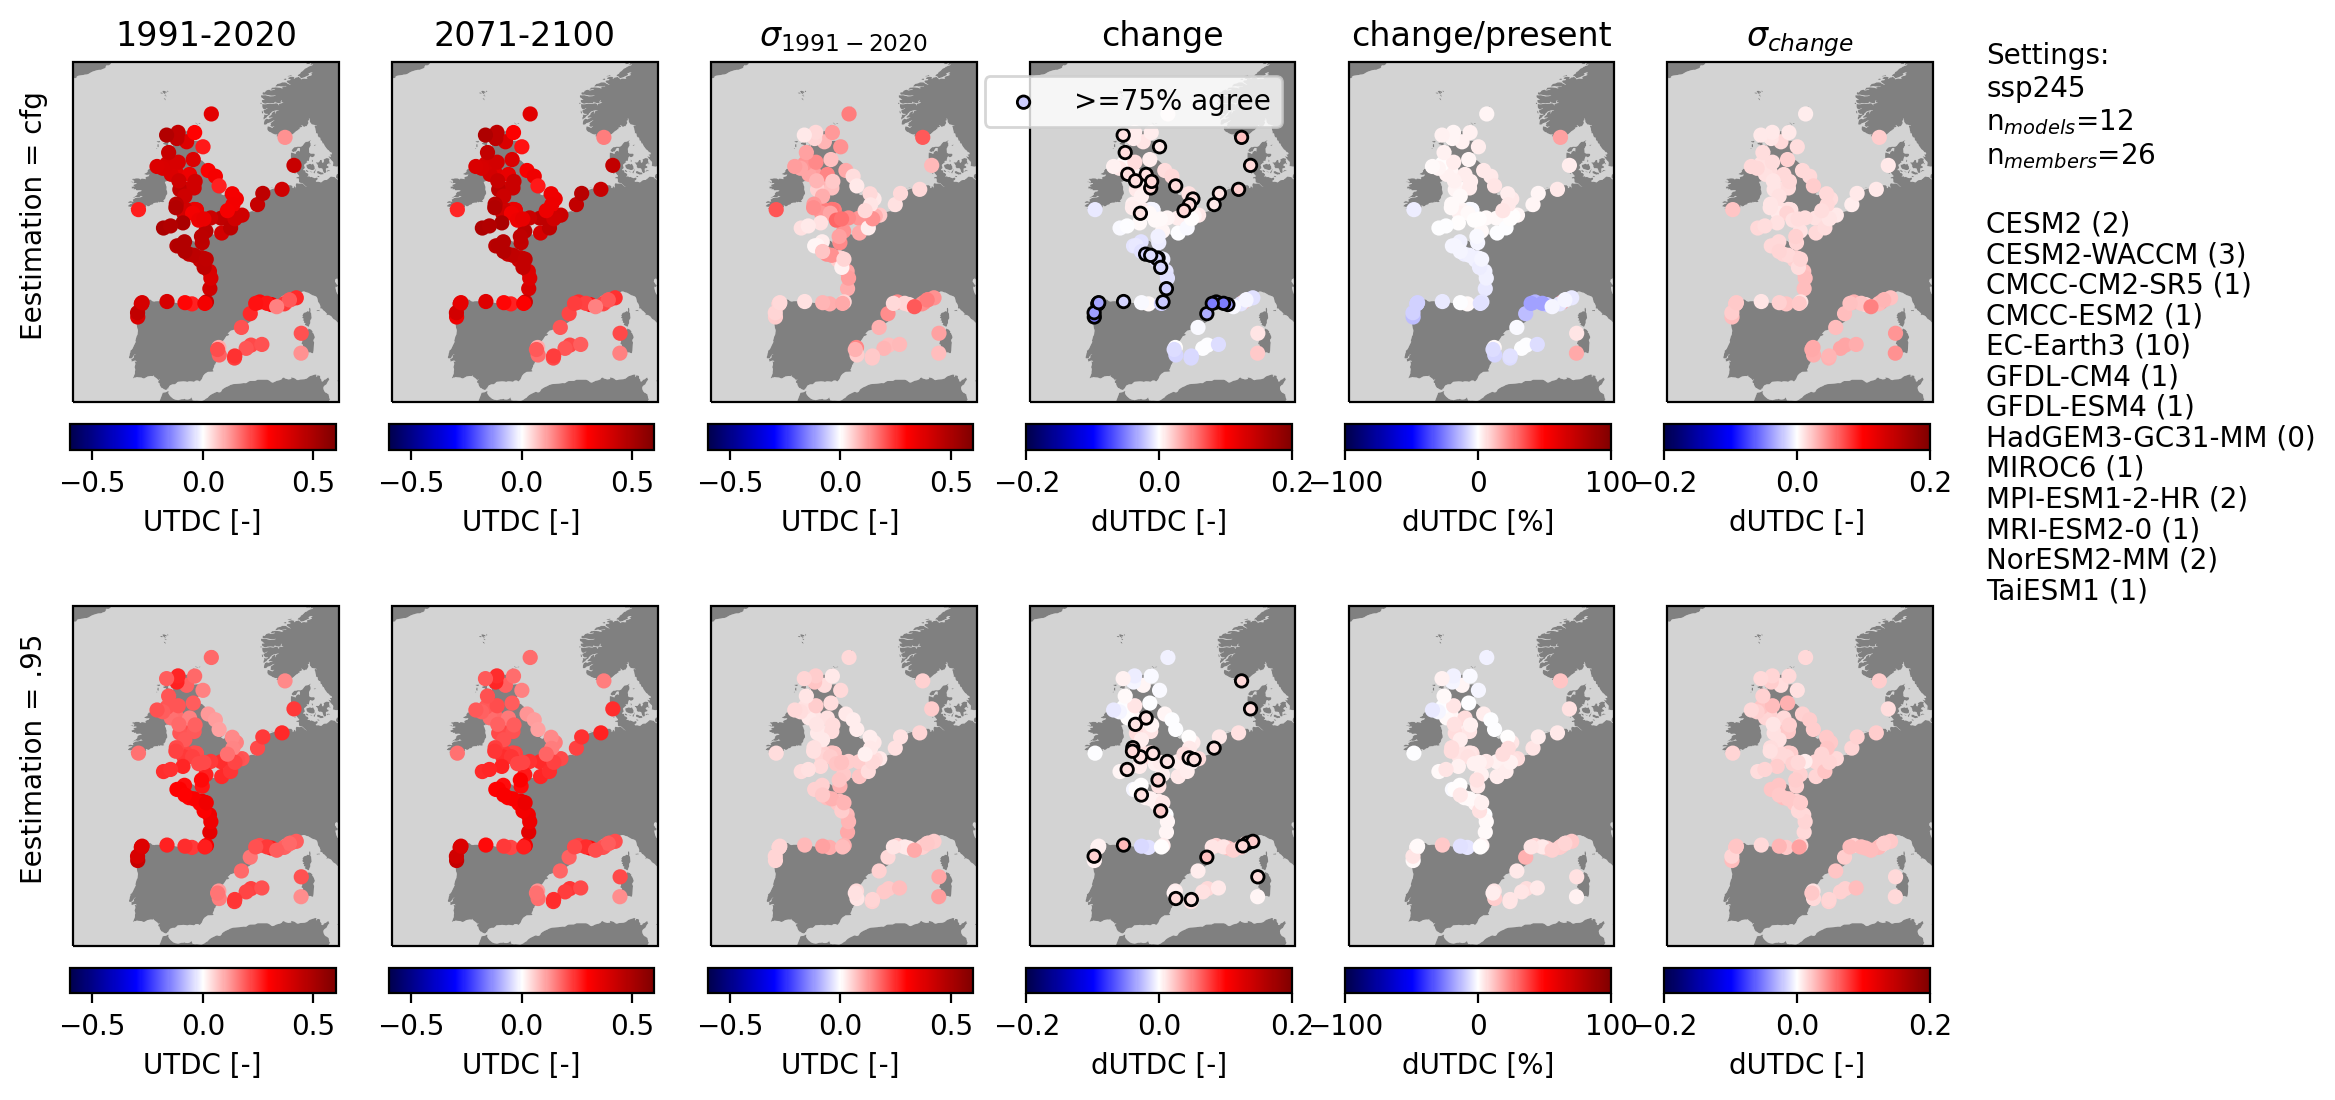

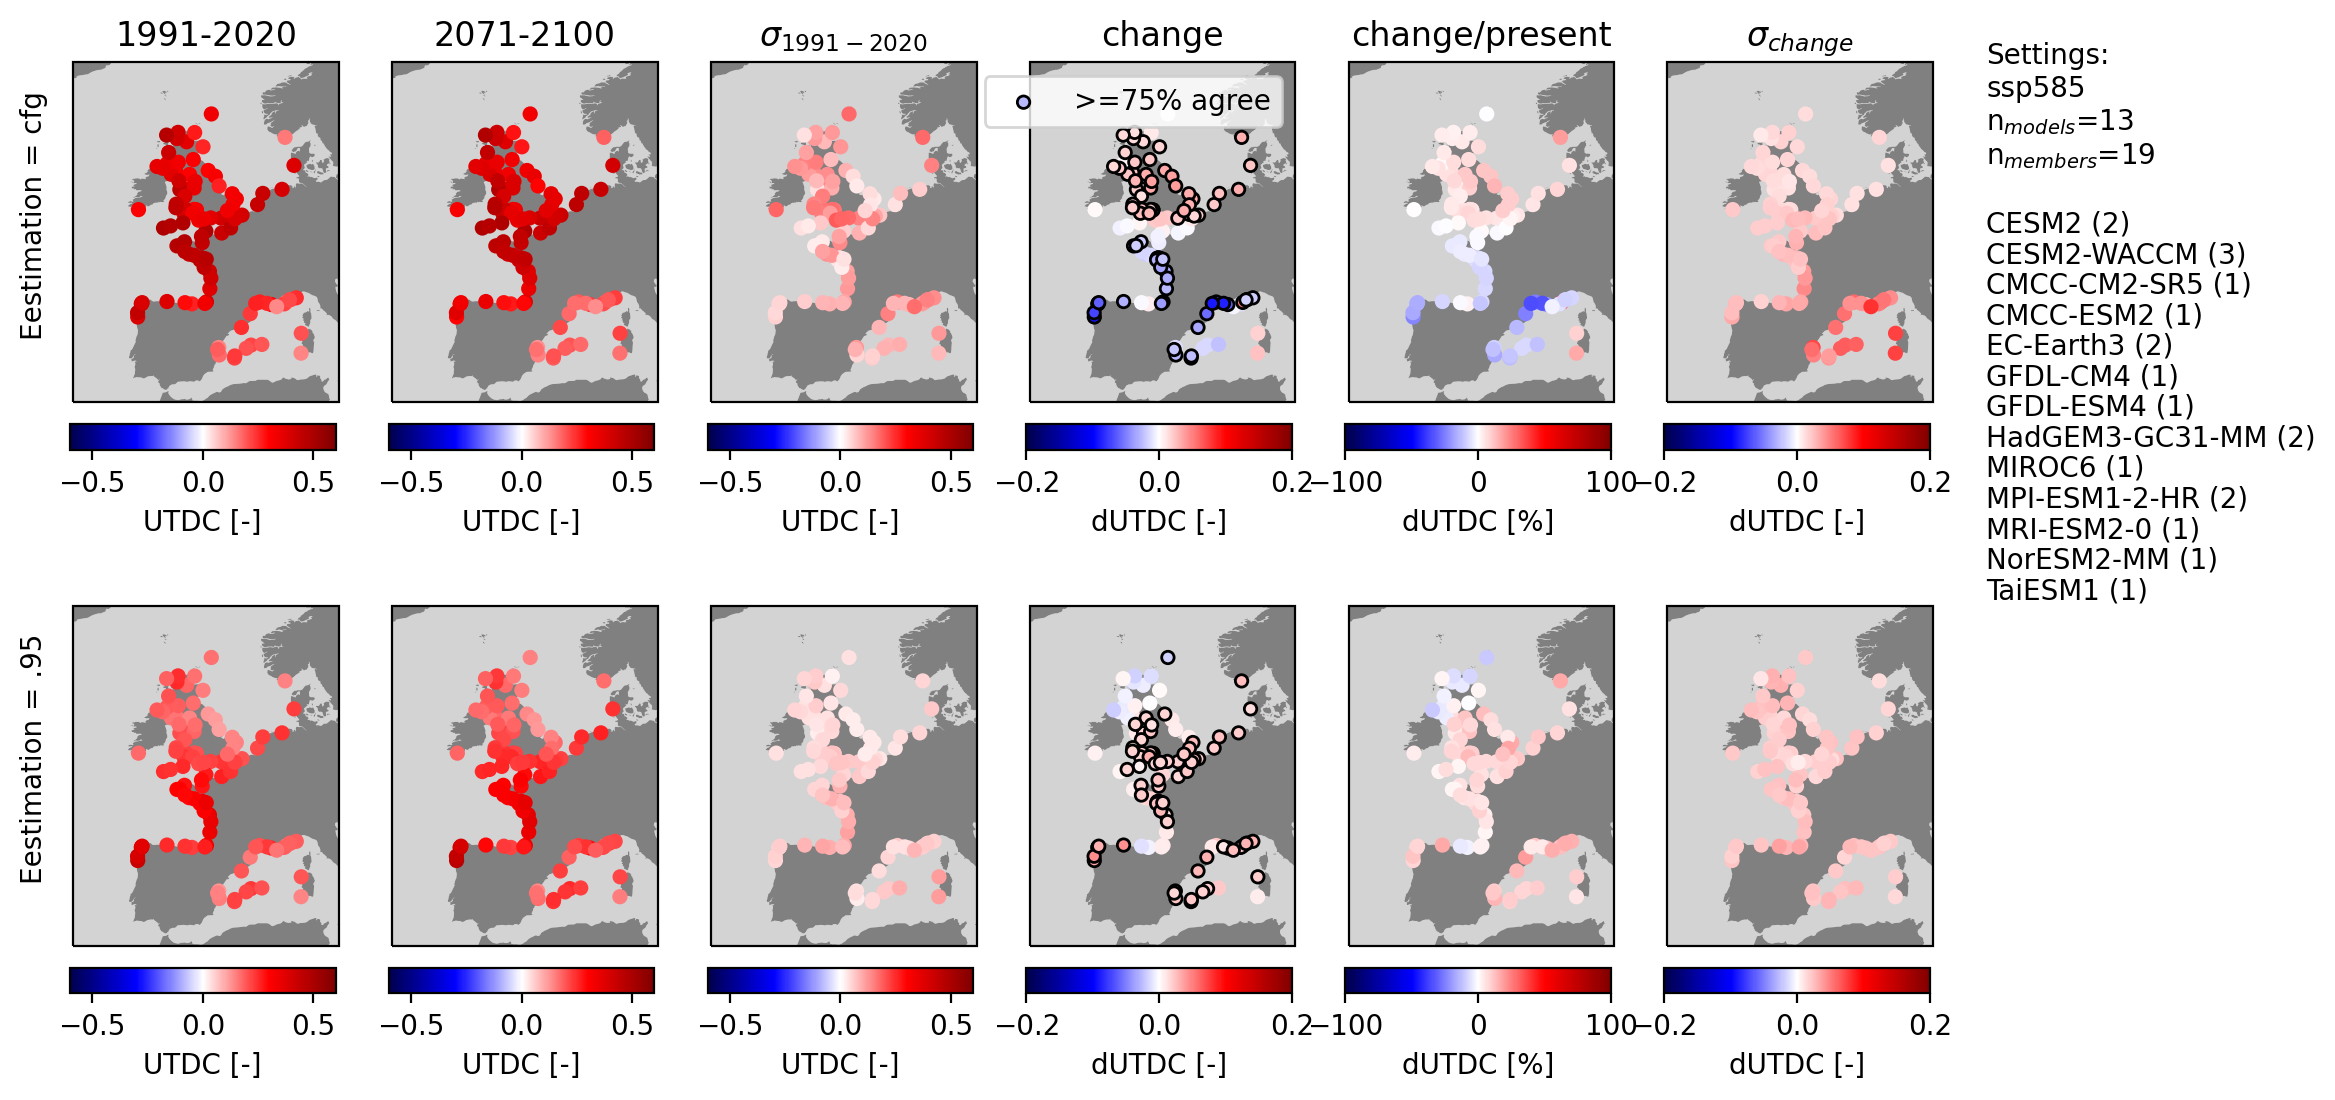

In [9]:
for ssp in ssps:
    ssp_ds = ds.sel(ssp=ssp)

    ssp_ds_present = ssp_ds.sel(window=2000)
    ssp_ds_future = ssp_ds.sel(window=2080)
    ssp_ds_diff = ssp_ds_future - ssp_ds_present

    fig=plt.figure(figsize=(12,10)) #generate figure  
    gs = fig.add_gridspec(3,6)

    for e,method in enumerate(ssp_ds_present.estimator.values):

        #1991-2020
        ax = plt.subplot(gs[e,0],projection=ccrs.Robinson(central_longitude=0))

        ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
        ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

        sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=ssp_ds_present.utdc.sel(statistic='coef',estimator=method).mean(dim='member_id').mean(dim='source_id'),cmap='seismic',vmin=-.6,vmax=.6,s=20,transform=ccrs.PlateCarree(),zorder=3)
        ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='UTDC [-]')
        if e==0:
            ax.set_title('1991-2020')

        ax.annotate('Eestimation = '+method,(-.2,.2),xycoords='axes fraction',rotation=90)

        #2071-2100
        ax = plt.subplot(gs[e,1],projection=ccrs.Robinson(central_longitude=0))

        ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
        ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

        sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=ssp_ds_future.utdc.sel(statistic='coef',estimator=method).mean(dim='member_id').mean(dim='source_id'),cmap='seismic',vmin=-.6,vmax=.6,s=20,transform=ccrs.PlateCarree(),zorder=3)
        ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='UTDC [-]')
        if e==0:
            ax.set_title('2071-2100')

        #standard present      
        ax = plt.subplot(gs[e,2],projection=ccrs.Robinson(central_longitude=0))

        ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
        ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

        sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=ssp_ds_present.utdc.sel(statistic='coef',estimator=method).mean(dim='member_id').std(dim='source_id'),cmap='seismic',vmin=-.6,vmax=.6,s=20,transform=ccrs.PlateCarree(),zorder=3)
        ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='UTDC [-]')
        if e==0:
            ax.set_title('$\sigma_{1991-2020}$')

        #change
        ax = plt.subplot(gs[e,3],projection=ccrs.Robinson(central_longitude=0))

        ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
        ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

        diff = ssp_ds_diff.utdc.sel(statistic='coef',estimator=method).mean(dim='member_id')
        ens_diff = ssp_ds_diff.utdc.sel(statistic='coef',estimator=method).mean(dim='member_id').mean(dim='source_id')

        num_agree = ((diff*ens_diff)>0).sum(dim='source_id')
        fraction_exceeds = (num_agree>=.75*len(diff.source_id))

        sc=ax.scatter(ssp_ds.lon[fraction_exceeds],ssp_ds.lat[fraction_exceeds],c=ens_diff[fraction_exceeds],cmap='seismic',edgecolor='black',vmin=-.2,vmax=.2,s=20,transform=ccrs.PlateCarree(),zorder=3,label='>=75% agree')
        sc=ax.scatter(ssp_ds.lon[~fraction_exceeds],ssp_ds.lat[~fraction_exceeds],c=ens_diff[~fraction_exceeds],cmap='seismic',vmin=-.2,vmax=.2,s=20,transform=ccrs.PlateCarree(),zorder=2)

        if e==0:
            ax.legend()

        ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='dUTDC [-]')
        if e==0:
            ax.set_title('change')


        #%change
        ax = plt.subplot(gs[e,4],projection=ccrs.Robinson(central_longitude=0))

        ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
        ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

        sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=100*ssp_ds_diff.utdc.sel(statistic='coef',estimator=method).mean(dim='member_id').mean(dim='source_id')/ssp_ds_present.utdc.sel(statistic='coef',estimator=method).mean(dim='member_id').mean(dim='source_id'),cmap='seismic',vmin=-100,vmax=100,s=20,transform=ccrs.PlateCarree(),zorder=3)
        ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='dUTDC [%]')
        if e==0:
            ax.set_title('change/present')

        #standard dev change       
        ax = plt.subplot(gs[e,5],projection=ccrs.Robinson(central_longitude=0))

        ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
        ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

        sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=ssp_ds_diff.utdc.sel(statistic='coef',estimator=method).mean(dim='member_id').std(dim='source_id'),cmap='seismic',vmin=-.2,vmax=.2,s=20,transform=ccrs.PlateCarree(),zorder=3)
        ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='dUTDC [-]')
        if e==0:
            ax.set_title('$\sigma_{change}$')
            n_models = np.sum(np.isfinite(ssp_ds_diff.isel(tg=0,estimator=0,statistic=0).utdc).sum(dim='member_id')>0).values
            n_members = np.sum(np.isfinite(ssp_ds_diff.isel(tg=0,estimator=0,statistic=0).utdc).sum(dim='member_id')).values
            ax.annotate('Settings:\n'+str(ssp)+'\nn$_{models}$='+str(n_models)+'\nn$_{members}$='+str(n_members),(1.2,.7),xycoords='axes fraction')
            list_models_members = [s+' ('+str(k)+')' for s,k in zip(ssp_ds_diff.source_id.values,np.isfinite(ssp_ds_diff.isel(tg=0,estimator=0,statistic=0).utdc).sum(dim='member_id').values)]
            for m,model in enumerate(list_models_members):
                ax.annotate(model,(1.2,.5-m*.09),xycoords='axes fraction')

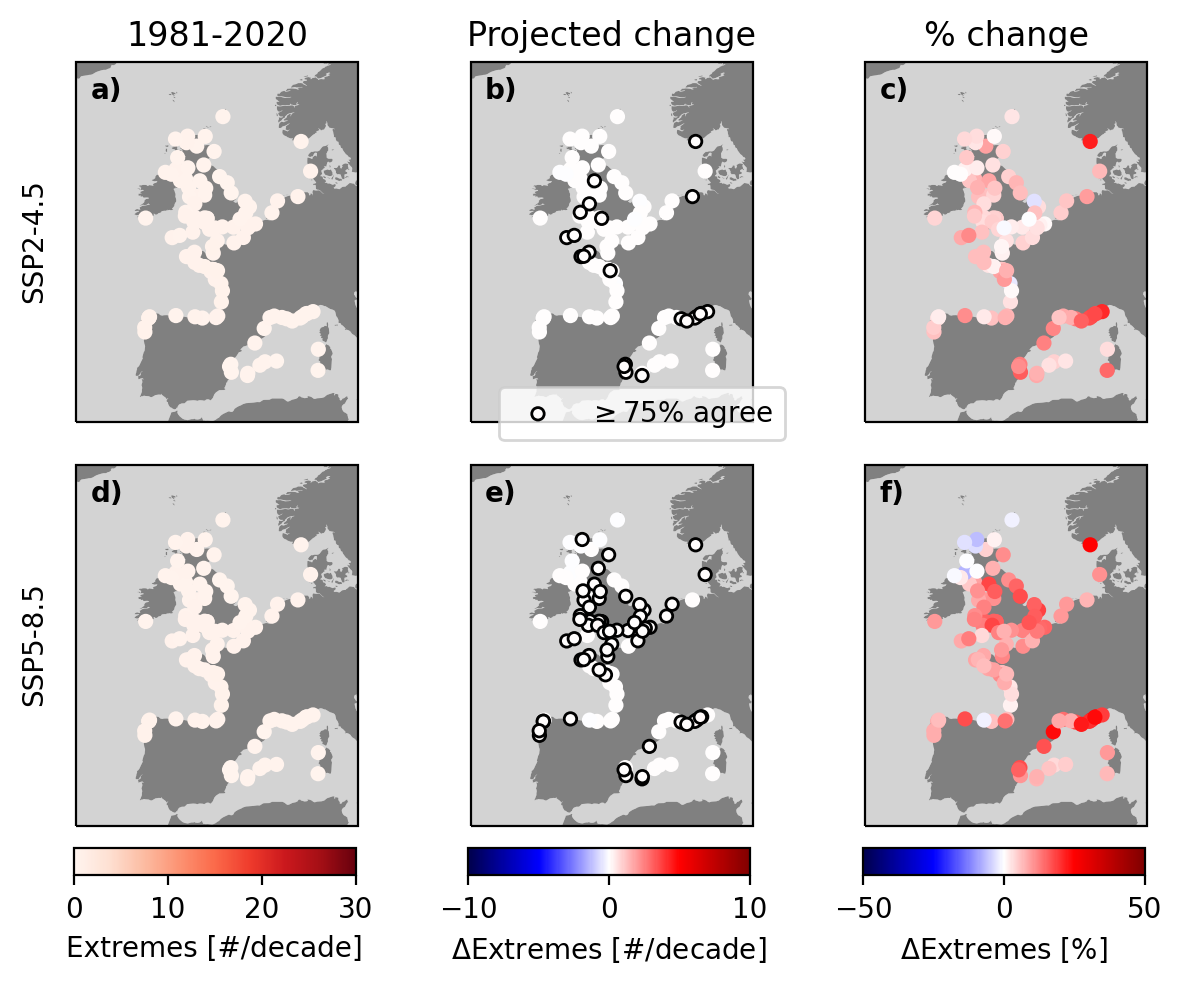

In [10]:
fig=plt.figure(figsize=(12,5)) #generate figure  
gs = fig.add_gridspec(2,5)
gs.update(wspace=.4,hspace=.1)
    
for s,ssp in enumerate(ssps):
    ssp_ds = ds_intersect.sel(ssp=ssp)

    ssp_ds_present = ssp_ds.sel(window=2000)#.sel(window=2005)
    ssp_ds_future = ssp_ds.sel(window=2080)#.sel(window=2085)
    ssp_ds_diff = ssp_ds_future - ssp_ds_present

    #1991-2020
    ax = plt.subplot(gs[s,0],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
    ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==1:
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Extremes [#/decade]')
    if s==0:
        ax.set_title('1981-2020')

    ax.annotate(['SSP2-4.5','SSP5-8.5'][s],(-.2,.35),xycoords='axes fraction',rotation=90)
    ax.annotate('ad'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')
        
    ax = plt.subplot(gs[s,1],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    
    diff = ssp_ds_diff.num_co_occurring.mean(dim='member_id')
    ens_diff = ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')

    num_agree = ((diff*ens_diff)>0).sum(dim='source_id')
    fraction_exceeds = (num_agree>=.75*len(diff.source_id))
        
    sc=ax.scatter(ssp_ds.lon[~fraction_exceeds],ssp_ds.lat[~fraction_exceeds],c=.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')[~fraction_exceeds],cmap='seismic',vmin=-10,vmax=10,s=20,transform=ccrs.PlateCarree(),zorder=3)
    sc=ax.scatter(ssp_ds.lon[fraction_exceeds],ssp_ds.lat[fraction_exceeds],c=.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')[fraction_exceeds],cmap='seismic',vmin=-10,vmax=10,s=20,edgecolor='black',transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree')
    
    ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('Projected change')
    if s==1:
        
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')    
        
    ax = plt.subplot(gs[s,2],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=(100*ssp_ds_diff.num_co_occurring/ssp_ds_present.num_co_occurring).mean(dim='member_id').mean(dim='source_id'),cmap='seismic',vmin=-50,vmax=50,s=20,transform=ccrs.PlateCarree(),zorder=3)
    ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==1:
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [%]')
    if s==0:
        ax.set_title('% change')
    ax.annotate('cf'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')
#meaning of number of joint extremes?

#fig.savefig('Figures/ensmean_num_joint_extremes_knmi.pdf',format='pdf',dpi=300,bbox_inches='tight')

In [ ]:
ssp_ds

In [ ]:
(100*ssp_ds_diff.num_co_occurring/ssp_ds_present.num_co_occurring).mean(dim='member_id').mean(dim='source_id').mean()

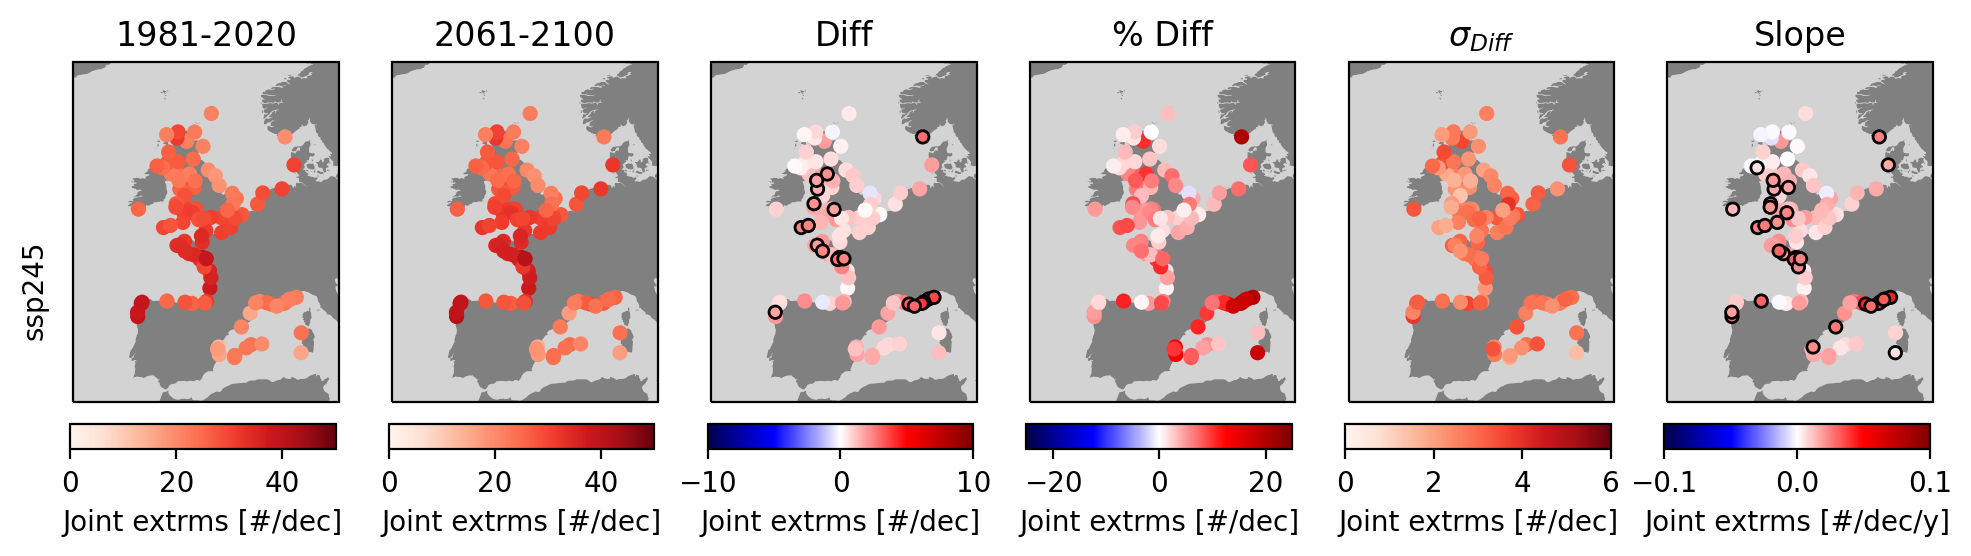

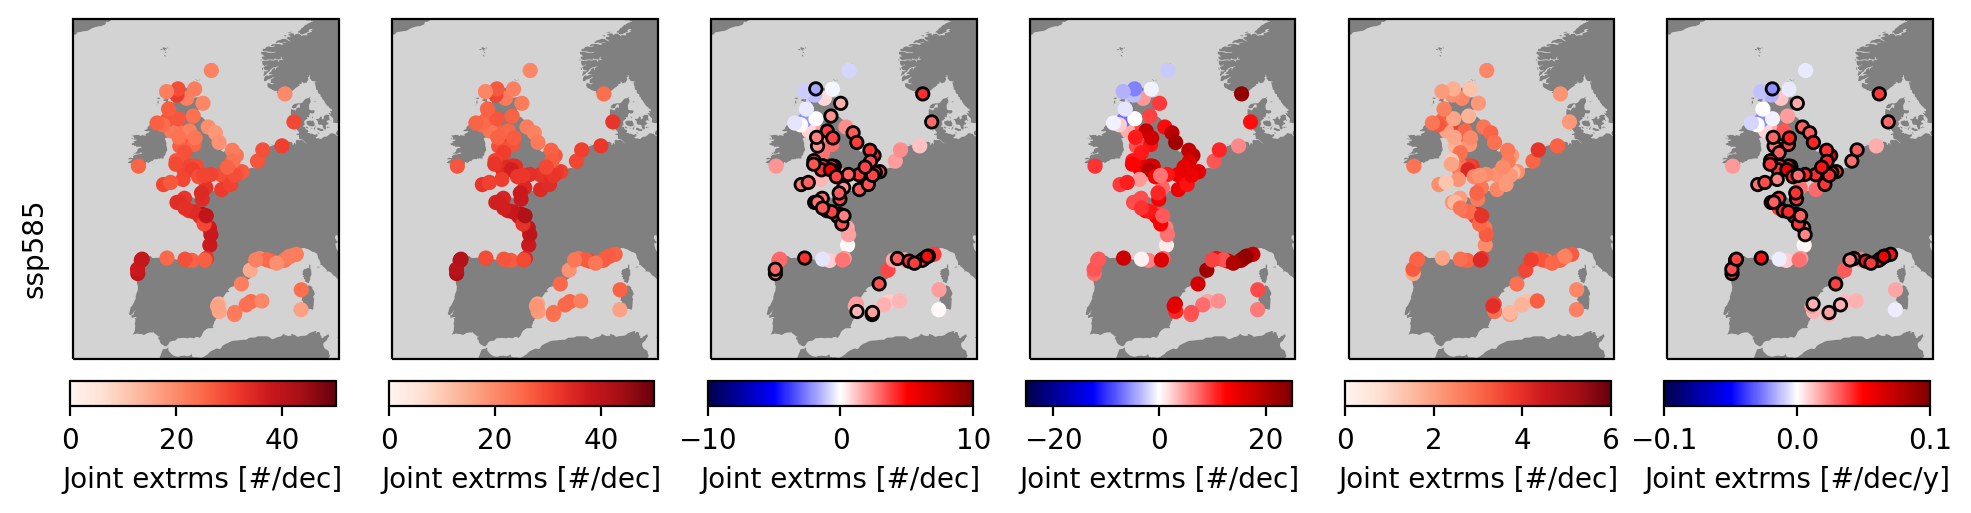

In [15]:
for s,ssp in enumerate(ssps):
    ssp_ds = ds_intersect.sel(ssp=ssp)

    ssp_ds_present = ssp_ds.sel(window=2000)#.sel(window=2005)
    ssp_ds_future = ssp_ds.sel(window=2080)#.sel(window=2085)
    ssp_ds_diff = ssp_ds_future - ssp_ds_present

    fig=plt.figure(figsize=(12,10)) #generate figure  
    gs = fig.add_gridspec(3,6)

    #1991-2020
    ax = plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=50,s=20,transform=ccrs.PlateCarree(),zorder=3)
    ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
    cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Joint extrms [#/dec]')
    if s==0:
        ax.set_title('1981-2020')

    ax.annotate(ssp,(-.2,.2),xycoords='axes fraction',rotation=90)
    
    #1991-2020
    ax = plt.subplot(gs[0,1],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_future.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=50,s=20,transform=ccrs.PlateCarree(),zorder=3)
    ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
    cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Joint extrms [#/dec]')
    if s==0:
        ax.set_title('2061-2100')

        
    ax = plt.subplot(gs[0,2],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    
    diff = ssp_ds_diff.num_co_occurring.mean(dim='member_id')
    ens_diff = ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')

    num_agree = ((diff*ens_diff)>0).sum(dim='source_id')
    fraction_exceeds = (num_agree>=.75*len(diff.source_id))
        
    sc=ax.scatter(ssp_ds.lon[~fraction_exceeds],ssp_ds.lat[~fraction_exceeds],c=.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')[~fraction_exceeds],cmap='seismic',vmin=-10,vmax=10,s=20,transform=ccrs.PlateCarree(),zorder=3)
    sc=ax.scatter(ssp_ds.lon[fraction_exceeds],ssp_ds.lat[fraction_exceeds],c=.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')[fraction_exceeds],cmap='seismic',vmin=-10,vmax=10,s=20,edgecolor='black',transform=ccrs.PlateCarree(),zorder=3)
    
    ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
    cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Joint extrms [#/dec]')
    if s==0:
        ax.set_title('Diff')
        
        
    ax = plt.subplot(gs[0,3],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=(100*ssp_ds_diff.num_co_occurring/ssp_ds_present.num_co_occurring).mean(dim='member_id').mean(dim='source_id'),cmap='seismic',vmin=-25,vmax=25,s=20,transform=ccrs.PlateCarree(),zorder=3)
    ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
    cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Joint extrms [#/dec]')
    if s==0:
        ax.set_title('% Diff')
        
    

    ax = plt.subplot(gs[0,4],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=(.25*ssp_ds_diff.num_co_occurring).mean(dim='member_id').std(dim='source_id'),cmap='Reds',vmin=0,vmax=6,s=20,transform=ccrs.PlateCarree(),zorder=3)
    ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
    cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Joint extrms [#/dec]')
    if s==0:
        ax.set_title('$\sigma_{Diff}$')

#meaning of number of joint extremes?

    ax = plt.subplot(gs[0,5],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    
    diff = ssp_ds.num_co_occurring_slope.mean(dim='member_id')
    ens_diff = ssp_ds.num_co_occurring_slope.mean(dim='member_id').mean(dim='source_id')

    num_agree = ((diff*ens_diff)>0).sum(dim='source_id')
    fraction_exceeds = (num_agree>=.75*len(diff.source_id))
        
    sc=ax.scatter(ssp_ds.lon[~fraction_exceeds],ssp_ds.lat[~fraction_exceeds],c=.25*ssp_ds.num_co_occurring_slope.mean(dim='member_id').mean(dim='source_id')[~fraction_exceeds],cmap='seismic',vmin=-.1,vmax=.1,s=20,transform=ccrs.PlateCarree(),zorder=3)
    sc=ax.scatter(ssp_ds.lon[fraction_exceeds],ssp_ds.lat[fraction_exceeds],c=.25*ssp_ds.num_co_occurring_slope.mean(dim='member_id').mean(dim='source_id')[fraction_exceeds],cmap='seismic',vmin=-.1,vmax=.1,s=20,edgecolor='black',transform=ccrs.PlateCarree(),zorder=3)
    
    ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
    cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Joint extrms [#/dec/y]')
    if s==0:
        ax.set_title('Slope')

